In [1]:

import pandas as pd
import numpy as np
import itertools
from ast import literal_eval
import re
from scipy import stats
from random import sample
#import scipy.stats as stats
import random
import statistics

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from  matplotlib.colors import LinearSegmentedColormap
from matplotlib_venn import venn2, venn2_circles
from matplotlib.pyplot import gcf
import seaborn as sns

In [3]:
sns.set_style("ticks")

In [4]:
from matplotlib_venn import venn3

In [5]:
plt.style.use('ggplot')

In [6]:
def HLA_cd8_converter(x):
    #define format of datetime
    return x.replace("[","").replace("]","").replace(",", "").replace("'","").split(" ")

def cdr3_lst_converter(x):
    #define format of datetime
    return x.replace("[","").replace("]","").replace("'","").split(" ")

def epitope_converter(x):
    #define format of datetime
    return [y for y in x.replace("[","").replace("]","").replace("\n","").split("'") if (y != '') & (y != ' ')]

def peptide_hla_converter(x):
    return re.findall("\w+\s{1}\w{1}\d+", x.replace("[","").replace("]","").replace("\n","").replace("'",""))

def literal_converter(val):
    # replace NaN with '' and perform literal eval on the rest
    return [] if val == '' else literal_eval(val)

converters = {'peptide_HLA_lst': peptide_hla_converter,
              'umi_count_lst_mhc': literal_eval,
              'umi_count_lst_TRA': literal_converter,'umi_count_lst_TRB': literal_converter,
              'cdr3_lst_TRA': cdr3_lst_converter,
              'cdr3_lst_TRB': cdr3_lst_converter,
              'HLA_lst_mhc': cdr3_lst_converter,'HLA_cd8': HLA_cd8_converter} #

In [7]:
import sys  
sys.path.insert(0, '../scripts')

from D_plot_specificity_matrix_utils import (peptide_per_clonotype_by_gem_size,
                                             multiple_peptides_per_gem_w_filtering,
                                             calc_binding_concordance,
                                             epitope_sorter_index,
                                             peptides_per_gem)

In [8]:
def get_unique_entries(df):
    return np.where((df.cdr3_TRA==a) & (df.cdr3_TRB==b), False, True)

def get_sample_size():
    inter_entries = get_unique_entries(inter_chains)
    inter_indexes = inter_chains[inter_entries].index.to_list()
    #print(sum(inter_entries), len(inter_indexes), sum(get_unique_entries(group)))
    return min(sum(get_unique_entries(group)), len(inter_indexes))

def add_similarity_scores(ai,bi):
    mat_a = sim_tra.loc[ai, a].reset_index(drop=True).T.reset_index(drop=True).T
    mat_b = sim_trb.loc[bi, b].reset_index(drop=True).T.reset_index(drop=True).T 
    return mat_a.add(mat_b)

def avg_similarity_scores(ai,bi):
    mat_a = sim_tra.loc[ai, a].reset_index(drop=True).T.reset_index(drop=True).T.to_frame().T
    mat_b = sim_trb.loc[bi, b].reset_index(drop=True).T.reset_index(drop=True).T.to_frame().T
    return pd.concat([mat_a, mat_b], ignore_index=True).mean() #.to_frame() is important?

def get_intra_similarity(cdr3_TRAs, cdr3_TRBs, method='sum'):
    unique_entries = get_unique_entries(group)
    unique_entry_indexes = group[unique_entries].index.to_list()

    sample_size = get_sample_size() 
    # Am I cheating myself by having the chance of not sampling the most similar chains?
    # There can be quite substantial size differences: 100x
    
    sampled_idxs = random.sample(unique_entry_indexes, sample_size)
    intra_a = group.loc[sampled_idxs, 'cdr3_TRA'].values
    intra_b = group.loc[sampled_idxs, 'cdr3_TRB'].values
    
    if method == 'sum':
        combined_similarity = add_similarity_scores(intra_a, intra_b)
    else:
        combined_similarity = avg_similarity_scores(intra_a, intra_b)
    return {'score': combined_similarity.max(),
            'fraction': sum(combined_similarity > 1.8)/len(combined_similarity)}

def get_inter_similarity(cdr3_TRAs, cdr3_TRBs, method='sum'):
    # OBS! make sure the size to sample from matches the number og unique entries intra_similarity! 
    unique_entries = get_unique_entries(inter_chains)
    unique_entry_indexes = inter_chains[unique_entries].index.to_list()

    sample_size = get_sample_size() # Am I cheating myself by having the chance of not sampling the most similar chains?

    sampled_idxs = random.sample(unique_entry_indexes, sample_size)
    inter_a = inter_chains.loc[sampled_idxs, 'cdr3_TRA'].values
    inter_b = inter_chains.loc[sampled_idxs, 'cdr3_TRB'].values
    
    if method == 'sum':
        combined_similarity = add_similarity_scores(inter_a, inter_b)
    else:
        combined_similarity = avg_similarity_scores(inter_a, inter_b)
    return {'score': combined_similarity.max(),
            'fraction': sum(combined_similarity > 1.8)/len(combined_similarity)}

def paired_t_test(x1, x2):
    assert len(x1) == len(x2)
    statistic, pvalue = stats.ttest_rel(x1, x2, alternative='greater')
    if (pvalue < 0.05) & (statistic > 0) & (len(x1) > 9):
        return {'test':True, 'pvalue':pvalue}
    else:
        return {'test':False, 'pvalue':pvalue}
    
def t_test(x1, x2):
    statistic, pvalue = stats.ttest_ind(x1, x2, equal_var=False, nan_policy='omit', alternative='less')
    if (pvalue < 0.05) & (statistic < 0) & (len(x1) > 9):
        return {'test':True, 'pvalue':pvalue}
    else:
        return {'test':False, 'pvalue':pvalue}

def add_number_of_observations(intra_lst, inter_lst):
    for box, lst in enumerate([intra_lst, inter_lst], start=1):
        if lst:
            median = statistics.median(lst)
            plt.text(box, median, "n: %i" %len(lst), ha='center', va='bottom')

def add_significance_bar(intra_lst, inter_lst):
    if len(intra_lst) == len(inter_lst):
        t = paired_t_test(intra_lst, inter_lst)#['pvalue']
        x = [1,1,2,2]
    else:
        t = t_test(intra_lst, inter_lst)
        x = [0,0,1,1]
    if t['test'] and t['pvalue'] < 0.05:
        pass
    else:
        return
    
    y0 =  max(max(intra_lst), max(inter_lst))
    y1 = y0 * 1.02
    y2 = y0 * 1.025
    y3 = y0 * 1.03
    y4 = y0 * 1.035

    plt.plot(x, [y1,y2,y2,y1], lw=1.5, c='k')
    plt.text(np.mean(x), y3, "p = %.2e" %t['pvalue'], ha='center', va='bottom', color='k')
    plt.plot(1, y4)
    
def add_counts(ax, plt_df, x_col, y_col, order, hue=None):
    if hue is None:
        d = 1
    else:
        d = len(hue)
    
    y_min = round(ax.get_ylim()[0], 2)
    x_pos = np.arange(len(order))
    y_pos = pd.Series([y_min]*len(order), index=order)
    counts = plt_df.dropna()[x_col].value_counts()/d
    counts = counts.reindex(order)
    
    if len(order) > 5:
        txt = '{:.0f}'
    else:
        txt = 'N={:.0f}'

    for p,n,m in zip(x_pos,counts,y_pos):
        if not np.isnan(m):
            ax.annotate(txt.format(n), xy=(p, m), xycoords='data', ha='center', va='bottom')

def plot_boxplot(intra_lst, inter_lst, title='Pooled'):
    plt.figure(figsize=(3,5))
    plt.boxplot([intra_lst, inter_lst], labels=['intra', 'inter'], widths=(0.5, 0.5))
    plt.title(title)
    plt.xlim(0.6, 2.4)
    plt.ylabel("Similarity")
    
    add_number_of_observations(intra_lst, inter_lst)
    add_significance_bar(intra_lst, inter_lst)
    
    #plt.show()

    #plt.savefig(get_file('boxplot'), bbox_inches='tight')
    #plt.cla()   # Clear axis
    #plt.clf()   # Clear figure
    #plt.close()

def plot_pieplot(significant_count, total_peptides):
    plt.pie([significant_count, total_peptides-significant_count],
            labels=['significant', 'insignificant'],
            autopct=lambda p: '{:.0f} ({:.0f}%)'.format(p * total_peptides / 100, p))
    plt.title("Proportion of significant outcomes (%i)" %total_peptides)
    plt.savefig(get_file('pieplot'), bbox_inches='tight')
    plt.cla()   # Clear axis
    plt.clf()   # Clear figure
    plt.close()

In [9]:
sim_dct = dict()

# Input
First fun for 1OS until (and including col_df = row_df.copy()). Then load 2OS and run the rest (skipping col_df = row_df.copy())

In [41]:
CAT_DIR = '/home/tuba/herpov/tcr-pmhc-sc-project/experiments/exp13/run2/cat/'
CAT_DIR = '../experiments/exp13/run2/cat/'

In [42]:
# OBS old
INPUT = CAT_DIR + 'tables/tcr_barcode.cleaned.csv'
#'/Volumes/tuba/herpov/tcr-pmhc-sc-project/data/exp9.2_CAT_IONTORRENT_KMA_AKB/tables/tcr_barcode.cleaned.csv'

In [43]:
VALID = CAT_DIR + "eval_clonotypes/valid_ct.csv"
#'/Volumes/tuba/herpov/tcr-pmhc-sc-project/data/exp9.2_CAT_IONTORRENT_KMA_AKB/reports/valid_ct.csv'

In [11]:
#TABLE = '/Volumes/tuba/herpov/tcr-pmhc-sc-project/data/exp9.2_CAT_IONTORRENT_KMA_AKB/reports/concordance_gridsearch.csv'

In [12]:
SIM_TRA = CAT_DIR + "/similarity_assessment/cdr3_a.csv"
#'/Volumes/tuba/herpov/tcr-pmhc-sc-project/data/exp9.2_CAT_IONTORRENT_KMA_AKB/similarity_assessment/cdr3/kernel_similarity_scores/cdr3_a.csv'
SIM_TRB = CAT_DIR + "/similarity_assessment/cdr3_b.csv"
#'/Volumes/tuba/herpov/tcr-pmhc-sc-project/data/exp9.2_CAT_IONTORRENT_KMA_AKB/similarity_assessment/cdr3/kernel_similarity_scores/cdr3_b.csv'

In [13]:
SIM_TRA = "../cdr3_a.csv"
SIM_TRB = "../cdr3_b.csv"

# Output

In [16]:
PLT = '/Volumes/tuba/herpov/tcr-pmhc-sc-project/plots/exp9.2_IONTORRENT_KMA_AKB/grid_search_similarity/'

# Load

In [14]:
#df = pd.read_csv(INPUT, converters=converters) #

In [44]:
valid_df = pd.read_csv(VALID, converters=converters)#.fillna('') #.fillna(0)

In [45]:
df = calc_binding_concordance(valid_df[(valid_df.umi_count_mhc >=2) &
                                       (valid_df.delta_umi_mhc >=1)].copy(), 'ct')

In [46]:
df.fillna({'umi_count_mhc':0, 'delta_umi_mhc':0, 'umi_count_mhc_rel':0,
           'umi_count_cd8':0, 'delta_umi_cd8':0,
           'umi_count_TRA':0, 'delta_umi_TRA':0,
           'umi_count_TRB':0, 'delta_umi_TRB':0,
           'cdr3_TRA':'','cdr3_TRB':''}, inplace=True)

In [18]:
#table = pd.read_csv(TABLE,index_col=0) #_archive

In [19]:
sim_tra = pd.read_csv(SIM_TRA, index_col=0).rename(index={'missing':''}, columns={'missing':''})
sim_trb = pd.read_csv(SIM_TRB, index_col=0).rename(index={'missing':''}, columns={'missing':''})

In [20]:
sim_tra = sim_tra[~sim_tra.index.duplicated()].copy() # Necessary?
sim_trb = sim_trb[~sim_trb.index.duplicated()].copy()

In [21]:
os1 = df.copy()

In [47]:
os2 = df.copy()

# Preprocess

In [48]:
len(valid_df.peptide_HLA.unique())

13

## Select the data to compute similarity on

In [49]:
row_df = df.groupby(['ct','cdr3_TRA','cdr3_TRB']).binding_concordance.max().to_frame().reset_index().drop_duplicates(subset='ct', keep='last')

In [50]:
row_df = row_df[~row_df.isin(['']).any(axis=1)].copy()
# Remove cts with missing chains

In [51]:
row_df

ct           cdr3_TRA           cdr3_TRB  binding_concordance
1       1.0     CGTEGAGNNRKLIW    CASSQVFGTPTPQHF             0.824121
3       2.0   CAVSDRSGGGADGLTF       CASSYVGYEQYF             0.517241
5       3.0    CAMREGMDSSYKLIF  CASSSHDRTGVRTEAFF             0.871795
7       4.0    CAVRAITGGGNKLTF   CASSTPSSGPQETQYF             0.894309
8       5.0    CAVDDGDNAGNMLTF        CASSGYNEQFF             0.400000
..      ...                ...                ...                  ...
914  7643.0    CATGSTQGGSEKLVF     CAVSWREGLNEQFF             1.000000
915  7664.0        CAYQWGGDMRF       CASSYVGYEQYF             1.000000
918  7673.0   CGTEEVENTGFQKLVF    CASSQVFGTPTPQHF             1.000000
920  7715.0       CILGSNTGKLIF  CSARDLAGSSGANVLTF             1.000000
922  7739.0  CAVNGPRMDTGRRALTF       CSVEESNTEAFF             1.000000

[616 rows x 4 columns]

In [52]:
dct = df.groupby(['ct','peptide_HLA']).binding_concordance.max().sort_values().to_frame().reset_index().drop_duplicates(subset='ct', keep='last').set_index(['ct']).peptide_HLA

In [53]:
row_df['peptide_HLA'] = row_df.ct.map(dct)

In [54]:
#dct = df.set_index('peptide_HLA')['rank'].to_dict()
dct = {'GILGFVFTL A0201': 1,
 'GLCTLVAML A0201': 2,
 'NLVPMVATV A0201': 3,
 'CLGGLLTMV A0201': 4,
 'FLYALALLL A0201': 5,
 'VLEETSVML A0201': 6,
 'YVLDHLIVV A0201': 7,
 'RVRAYTYSK A0301': 8,
 'RPHERNGFTV B0702': 9,
 'RPHERNGFTVL B0702': 10,
 'RPPIFIRRL B0702': 11,
 'TPRVTGGGAM B0702': 12,
 'TPSVSSSISSL B0702': 13}
row_df['epitope_rank'] = row_df.peptide_HLA.map(dct)

In [55]:
dct = df.set_index('peptide_HLA').HLA_mhc.to_dict()
row_df['HLA_mhc'] = row_df.peptide_HLA.map(dct)

In [56]:
#df['HLA_match_per_gem'] = df.apply(lambda row: row.HLA_mhc in row.HLA_cd8, axis=1).astype(int)

In [57]:
dct = df.groupby(['ct','peptide_HLA']).HLA_cd8.apply(list)
row_df['HLA_lst'] = row_df.set_index(['ct','peptide_HLA']).index.map(dct)

In [58]:
row_df['n_gems'] = row_df.apply(lambda row: len(row.HLA_lst), axis=1)
row_df['HLA_match_count'] = row_df.apply(lambda row: sum([row.HLA_mhc in hlas for hlas in row.HLA_lst]), axis=1)
row_df['HLA_match_ratio'] = row_df.apply(lambda row: row.HLA_match_count/len(row.HLA_lst), axis=1)
row_df['HLA_match_str'] = row_df.apply(lambda row: f'{row.HLA_match_count}/{len(row.HLA_lst)}', axis=1)
row_df['HLA_match'] = row_df.apply(lambda row: 0.5 < row.HLA_match_ratio, axis=1).astype(int)

In [59]:
row_df

ct           cdr3_TRA           cdr3_TRB  binding_concordance  \
1       1.0     CGTEGAGNNRKLIW    CASSQVFGTPTPQHF             0.824121   
3       2.0   CAVSDRSGGGADGLTF       CASSYVGYEQYF             0.517241   
5       3.0    CAMREGMDSSYKLIF  CASSSHDRTGVRTEAFF             0.871795   
7       4.0    CAVRAITGGGNKLTF   CASSTPSSGPQETQYF             0.894309   
8       5.0    CAVDDGDNAGNMLTF        CASSGYNEQFF             0.400000   
..      ...                ...                ...                  ...   
914  7643.0    CATGSTQGGSEKLVF     CAVSWREGLNEQFF             1.000000   
915  7664.0        CAYQWGGDMRF       CASSYVGYEQYF             1.000000   
918  7673.0   CGTEEVENTGFQKLVF    CASSQVFGTPTPQHF             1.000000   
920  7715.0       CILGSNTGKLIF  CSARDLAGSSGANVLTF             1.000000   
922  7739.0  CAVNGPRMDTGRRALTF       CSVEESNTEAFF             1.000000   

           peptide_HLA  epitope_rank HLA_mhc  \
1      VLEETSVML A0201             6   A0201   
3      RVRAYTYSK A0301             8   A0301   
5     TPRVTGGGAM B0702            12   B0702   
7    RPHERNGFTVL B0702            10   B0702   
8      RVRAYTYSK A0301             8   A0301   
..                 ...           ...     ...   
914    RVRAYTYSK A0301             8   A0301   
915    RVRAYTYSK A0301             8   A0301   
918    VLEETSVML A0201             6   A0201   
920    YVLDHLIVV A0201             7   A0201   
922    VLEETSVML A0201             6   A0201   

                                               HLA_lst  n_gems  \
1    [[A0201, A0301], [A0201, A0301], [A0201, A0301...     164   
3    [[A0201, A0301], [A0201, A0301], [A0201, A0301...      15   
5    [[B0702], [B0702], [B0702], [B0702], [B0702], ...     102   
7    [[B0702], [B0702], [B0702], [B0702], [B0702], ...     110   
8                     [[A0201, A0301], [A0201, A0301]]       2   
..                                                 ...     ...   
914                                          [[A0201]]       1   
915                                   [[A0301, B0702]]       1   
918                                   [[A0201, A0301]]       1   
920                                   [[A0201, A0301]]       1   
922                                   [[A0201, A0301]]       1   

     HLA_match_count  HLA_match_ratio HLA_match_str  HLA_match  
1                163         0.993902       163/164          1  
3                 15         1.000000         15/15          1  
5                102         1.000000       102/102          1  
7                108         0.981818       108/110          1  
8                  2         1.000000           2/2          1  
..               ...              ...           ...        ...  
914                0         0.000000           0/1          0  
915                1         1.000000           1/1          1  
918                1         1.000000           1/1          1  
920                1         1.000000           1/1          1  
922                1         1.000000           1/1          1  

[616 rows x 13 columns]

In [60]:
#dct = df.groupby(['ct','peptide_HLA']).HLA_match_per_gem.apply(lambda x: sum(x)/len(x))
#row_df['HLA_match'] = row_df.set_index(['ct','peptide_HLA']).index.map(dct)

In [61]:
#dct = df.groupby(['ct','peptide_HLA']).HLA_match_per_gem.apply(lambda x: f'{sum(x)}/{len(x)}')
#row_df['HLA_match_str'] = row_df.set_index(['ct','peptide_HLA']).index.map(dct)

In [62]:
peptides = ['GILGFVFTL A0201', 'GLCTLVAML A0201', 'NLVPMVATV A0201',
       'CLGGLLTMV A0201', 'FLYALALLL A0201', 'VLEETSVML A0201',
       'YVLDHLIVV A0201', 'RVRAYTYSK A0301', 'RPHERNGFTV B0702',
       'RPHERNGFTVL B0702', 'RPPIFIRRL B0702', 'TPRVTGGGAM B0702',
       'TPSVSSSISSL B0702']

In [63]:
import matplotlib

col_pep = list()
cmap = plt.get_cmap('jet', len(peptides))#len(row_df.peptide_HLA.unique())
for i in range(cmap.N):
    col_pep.append(matplotlib.colors.rgb2hex(cmap(i)))
#col_pep = ['#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3','#fdb462','#b3de69','#fccde5','#d9d9d9','#bc80bd','#ccebc5','#ffed6f','#525252']

dct = dict(zip(peptides, col_pep))
row_df['col_pep'] = row_df.peptide_HLA.map(dct)

In [64]:
#import matplotlib
#
#col_hla = list()
#cmap = plt.get_cmap('spring', len(row_df.HLA_mhc.unique()))
#for i in range(cmap.N):
#    col_hla.append(matplotlib.colors.rgb2hex(cmap(i)))
##col_hla = ['#8dd3c7','#ffffb3','#bebada']

In [65]:
col_hla = list()
#cmap = plt.get_cmap('spring') #, len(row_df.HLA_mhc.unique())
cmap_hla = LinearSegmentedColormap.from_list('hla',['#4b006e','magenta'], N=256) #'#922b05','#b27a01'
#cmap = plt.get_cmap('RdPu')
#cmap = LinearSegmentedColormap.from_list('new_name',cmap(np.linspace(0.5, 1, 256)))
for i in row_df.HLA_match_ratio.unique():
    col_hla.append(matplotlib.colors.rgb2hex(cmap_hla(i)))
    
dct = dict(zip(row_df.HLA_match_ratio.unique(), col_hla))
row_df['col_hla'] = row_df.HLA_match_ratio.map(dct)

In [66]:
row_df.sort_values(by=['epitope_rank','peptide_HLA','HLA_match_ratio','HLA_match_count'], ascending=[True, True, False, False], inplace=True)

In [40]:
col_df = row_df.copy()

In [67]:
mat_tra = sim_tra.loc[row_df.cdr3_TRA, col_df.cdr3_TRA]
mat_trb = sim_trb.loc[row_df.cdr3_TRB, col_df.cdr3_TRB]

In [68]:
mat_tra = (sim_tra.loc[row_df.cdr3_TRA, col_df.cdr3_TRA] == 1).astype(int) * 0.333
mat_trb = (sim_trb.loc[row_df.cdr3_TRB, col_df.cdr3_TRB] == 1).astype(int) * 0.666

In [69]:
mat_tra.index = row_df.ct
mat_trb.index = row_df.ct
mat_tra.columns = col_df.ct
mat_trb.columns = col_df.ct

In [70]:
mat_sum = mat_tra.add(mat_trb)

In [71]:
cmap=LinearSegmentedColormap.from_list('w',['#f7f7f7','#cccccc','#969696','#525252'], N=256) #'#fbfbfb','#fdfdfe','#f7f7f7'

In [72]:
col_sim = list()
#ctmp = LinearSegmentedColormap.from_list('g',["w", "g", 'black'], N=4)
for i in [0.333, 0.666, 0.999]: #range(ctmp.N):
    col_sim.append(matplotlib.colors.rgb2hex(cmap(i)))

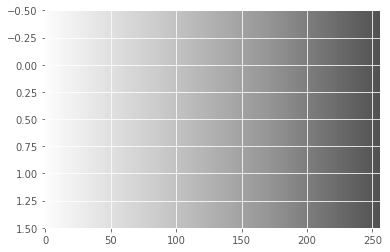

In [73]:
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))
#plt.imshow(gradient, aspect='auto', cmap=LinearSegmentedColormap.from_list('w',['magenta','#4b006e'], N=256))#'#922b05','#b27a01'
#plt.imshow(gradient, aspect='auto', cmap=cmap)
plt.imshow(gradient, aspect='auto', cmap=LinearSegmentedColormap.from_list('w',['#fdfdfe','#cccccc','#969696','#525252'], N=256))

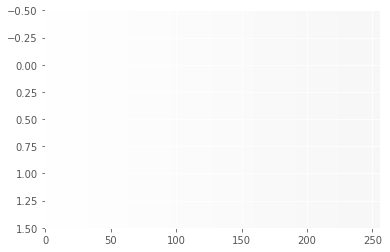

In [74]:
cmap_tester = LinearSegmentedColormap.from_list('w',['white','#f7f7f7'], N=256)
lol = matplotlib.colors.rgb2hex(cmap_tester(0.5))
plt.imshow(gradient, aspect='auto', cmap=cmap_tester)


In [75]:
cols = ['ct','peptide_HLA','peptide_HLA_lst','umi_count_lst_mhc','HLA_cd8','umi_count_cd8',
                           'umi_count_lst_TRA','umi_count_lst_TRB','gems_per_specificity',
                           'gems_per_clonotype','binding_concordance']

In [82]:
def plot_gem_distribution():
    c_1os = set(pm1.index).intersection(set(pm2.index))
    c_2os = set(pm2.values).intersection(set(pm1.values))
    b_1os = set(pm1.index) - set(pm2.index)
    b_2os = set(pm2.values) - set(pm1.values)
    a_1os = set(col_df[col_df.peptide_HLA == pep].ct) - b_1os - c_1os
    a_2os = set(row_df[row_df.peptide_HLA == pep].ct) - b_2os - c_2os
    
    labels = ('no intersection', 'alt. intersection', 'pMHC intersection')
    
    dfs = list()
    for os, df, sets in [('2OS', row_df, (a_2os, b_2os, c_2os)), ('1OS', col_df, (a_1os, b_1os, c_1os))]:
        for s,l in zip(sets, labels):
            tmp = df.loc[df.ct.isin(s), ['n_gems','HLA_match_ratio']]
            tmp['label'] = l
            tmp['os'] = os
            dfs.append(tmp)
            
    plt_df = pd.concat(dfs)
    
    color = list()
    for i in plt_df.HLA_match_ratio:
        color.append(matplotlib.colors.rgb2hex(cmap_hla(i)))
    plt_df['col_hla'] = color
    plt_df['pep'] = pep

    g = sns.catplot(data=plt_df, x='n_gems', y='os', hue='label', kind='box', palette=col_sim, fliersize=0, hue_order=labels) #palette=col_sim
    g.map_dataframe(sns.stripplot,x='n_gems', y='os', hue='label', hue_order=labels, dodge=True, alpha=1, palette=color, jitter=0.3) #palette=color
    for ax in g.axes.flatten():
        #ax.tick_params(axis='y', which='both', direction='out', length=4, left=True)
        ax.grid(b=True, which='both', axis='x', color='gray', linewidth=0.1)
        ax.set_xlim(0,plt_df.n_gems.max()+1)
    #sns.despine(trim=True)
    plt.show()
    
    return plt_df

In [77]:
def compute_accuracy():
    # All matches
    match_df = tmp.where(tmp > 0.9).dropna(how='all').dropna(how='all', axis=1)
    sum_all = (row_df[row_df.ct.isin(match_df.index)].n_gems.sum() +
               col_df[col_df.ct.isin(match_df.columns)].n_gems.sum())
    
    # All matches within the queried peptide
    ct_pep_1os = match_df.columns.isin(grp_col.ct.unique())
    ct_pep_2os = match_df.index.isin(grp_row.ct.unique())
    pep_match_df = match_df.loc[ct_pep_2os, ct_pep_1os].dropna(how='all').dropna(how='all', axis=1)

    acc_all = (grp_row[grp_row.ct.isin(pep_match_df.index)].n_gems.sum() +
               grp_col[grp_col.ct.isin(pep_match_df.columns)].n_gems.sum()) / sum_all
    
    acc_ct = (pep_match_df > 0.9).sum().sum() / (match_df > 0.9).sum().sum()
    
    # All matches with HLA match
    ct_pep_1os = match_df.columns.isin(col_df[col_df.HLA_match == 1].ct.unique())
    ct_pep_2os = match_df.index.isin(row_df[row_df.HLA_match == 1].ct.unique())
    pep_match_df = match_df.loc[ct_pep_2os, ct_pep_1os].dropna(how='all').dropna(how='all', axis=1)
    sum_hla = (row_df[row_df.ct.isin(pep_match_df.index)].n_gems.sum() +
               col_df[col_df.ct.isin(pep_match_df.columns)].n_gems.sum())
    
    neder = (pep_match_df > 0.9).sum().sum()
    
    # All matches within the queried peptide and whit HLA match
    ct_pep_1os = match_df.columns.isin(grp_col[grp_col.HLA_match == 1].ct.unique())
    ct_pep_2os = match_df.index.isin(grp_row[grp_row.HLA_match == 1].ct.unique())
    pep_match_df = match_df.loc[ct_pep_2os, ct_pep_1os].dropna(how='all').dropna(how='all', axis=1)
    acc_hla = (grp_row[grp_row.ct.isin(pep_match_df.index)].n_gems.sum() +
               grp_col[grp_col.ct.isin(pep_match_df.columns)].n_gems.sum()) / sum_hla
    
    acc_ct_hla = (pep_match_df > 0.9).sum().sum() / neder
    
    return round(acc_ct, 3), round(acc_all, 3), round(acc_ct_hla, 3), round(acc_hla, 3)

CLGGLLTMV A0201


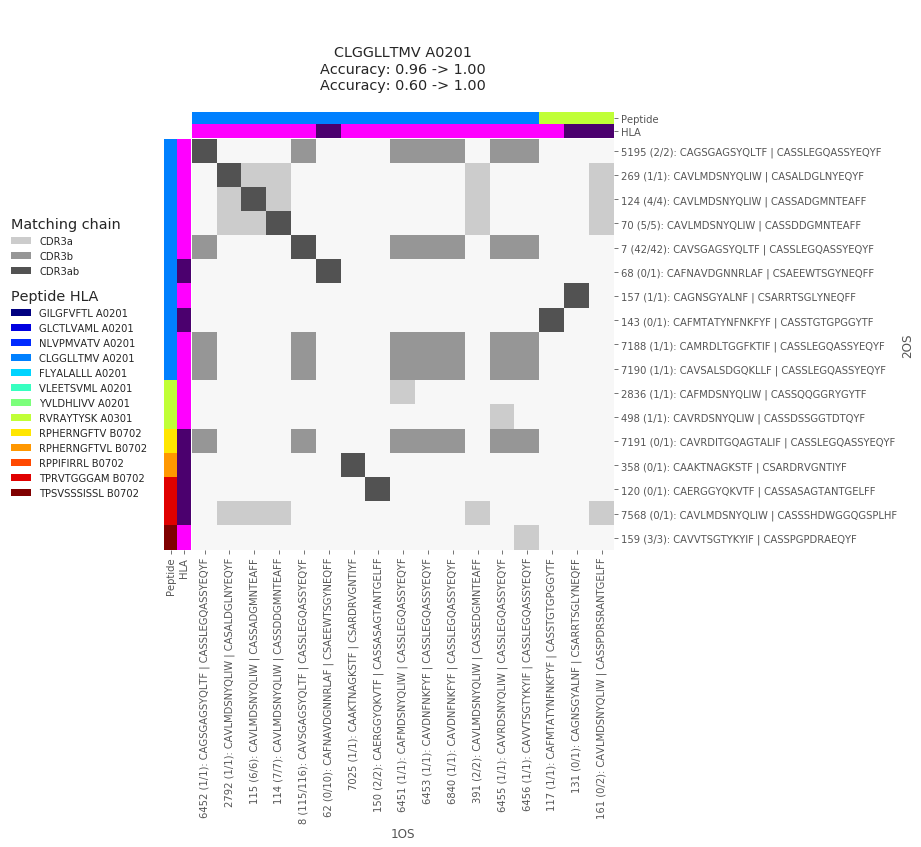

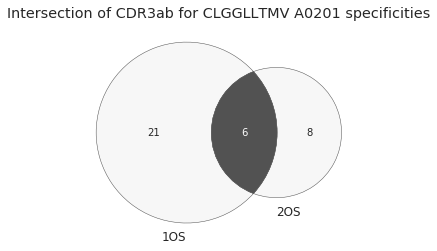

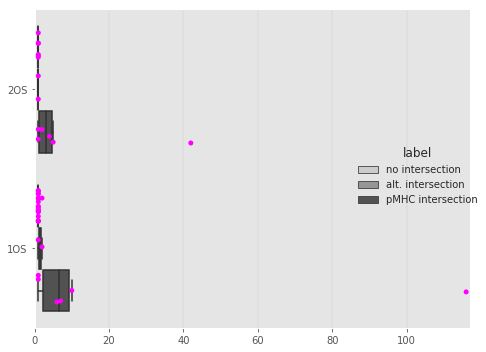

FLYALALLL A0201


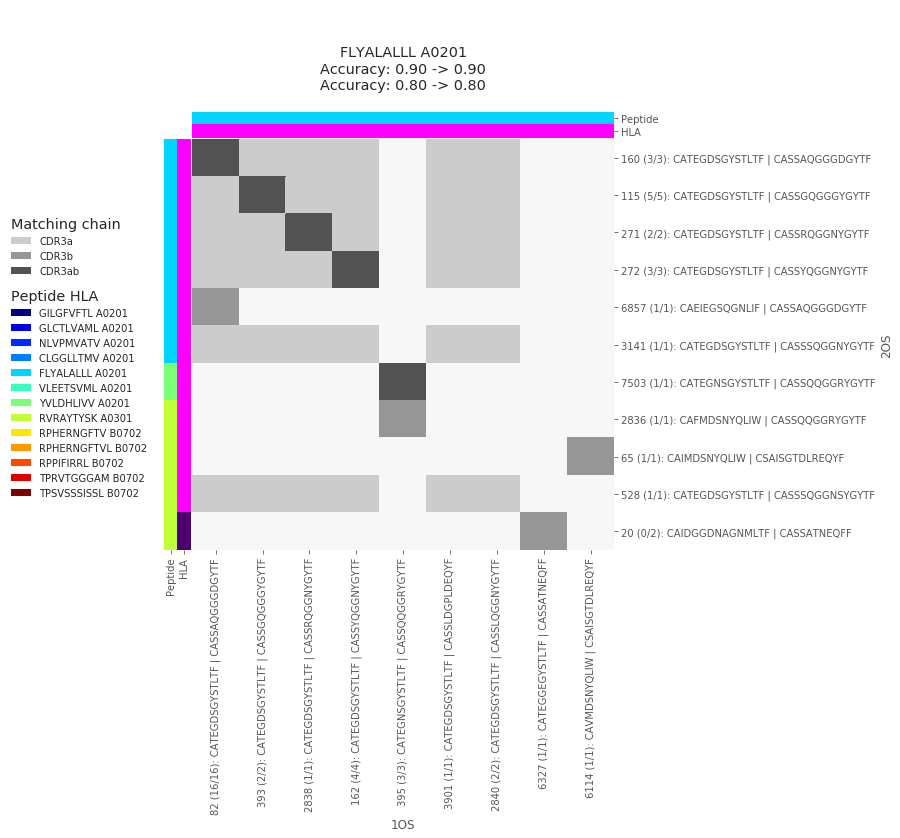

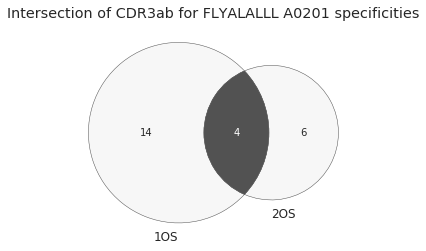

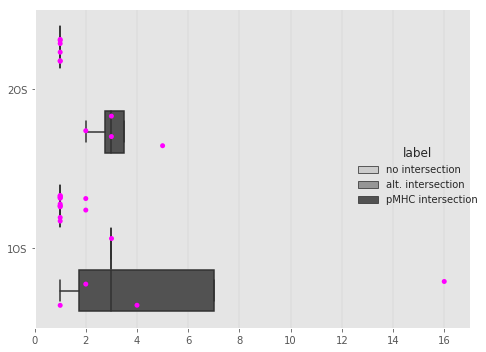

GILGFVFTL A0201
GLCTLVAML A0201


/home/people/herpov/.conda/envs/snakemake/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in double_scalars
/home/people/herpov/.conda/envs/snakemake/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in long_scalars
/home/people/herpov/.conda/envs/snakemake/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars


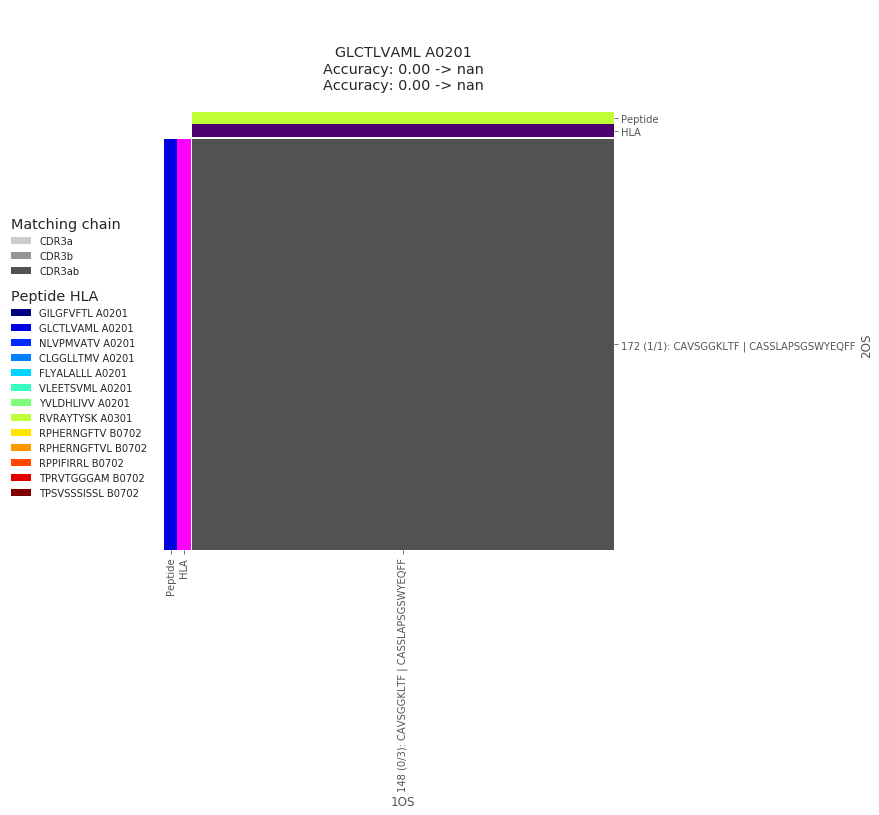

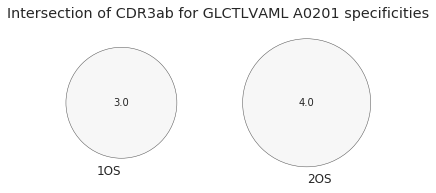

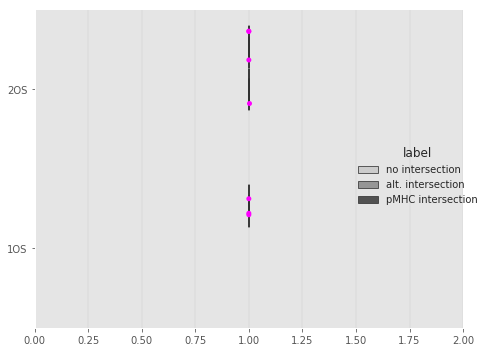

NLVPMVATV A0201


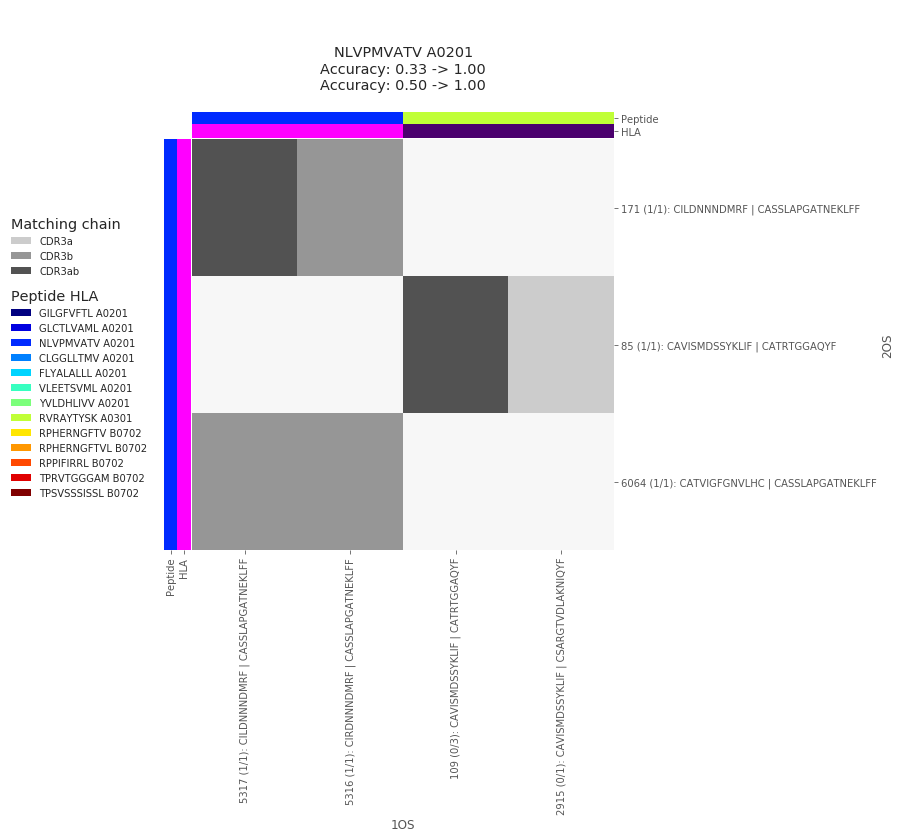

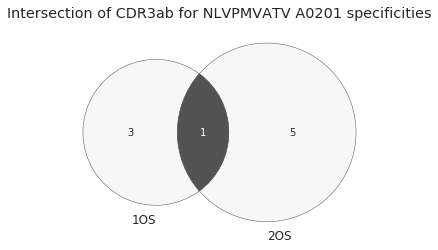

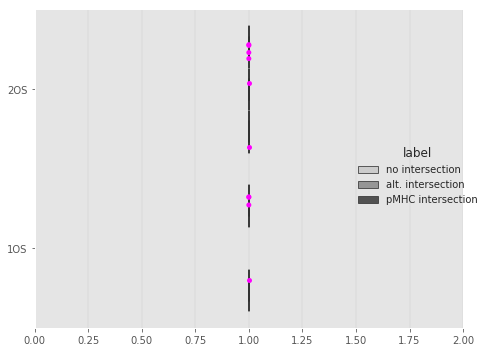

RPHERNGFTV B0702


/home/people/herpov/.conda/envs/snakemake/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in long_scalars


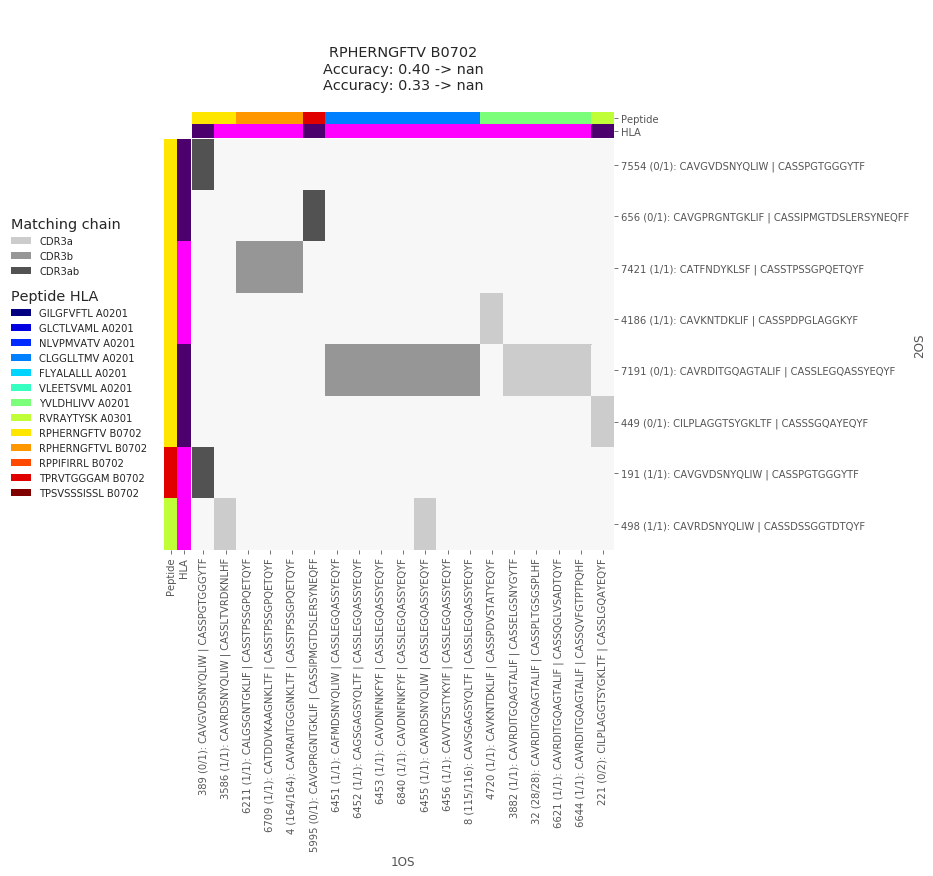

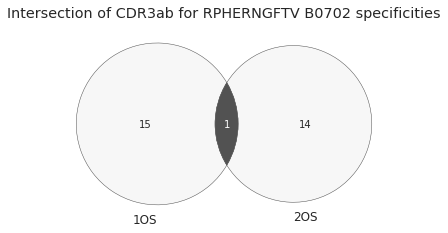

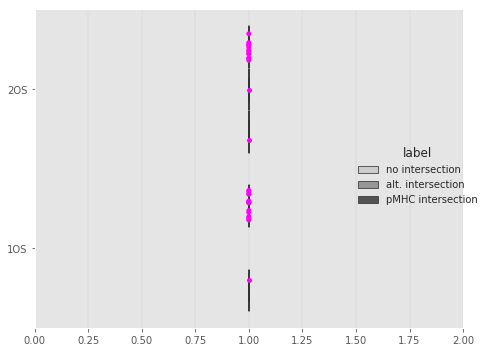

RPHERNGFTVL B0702


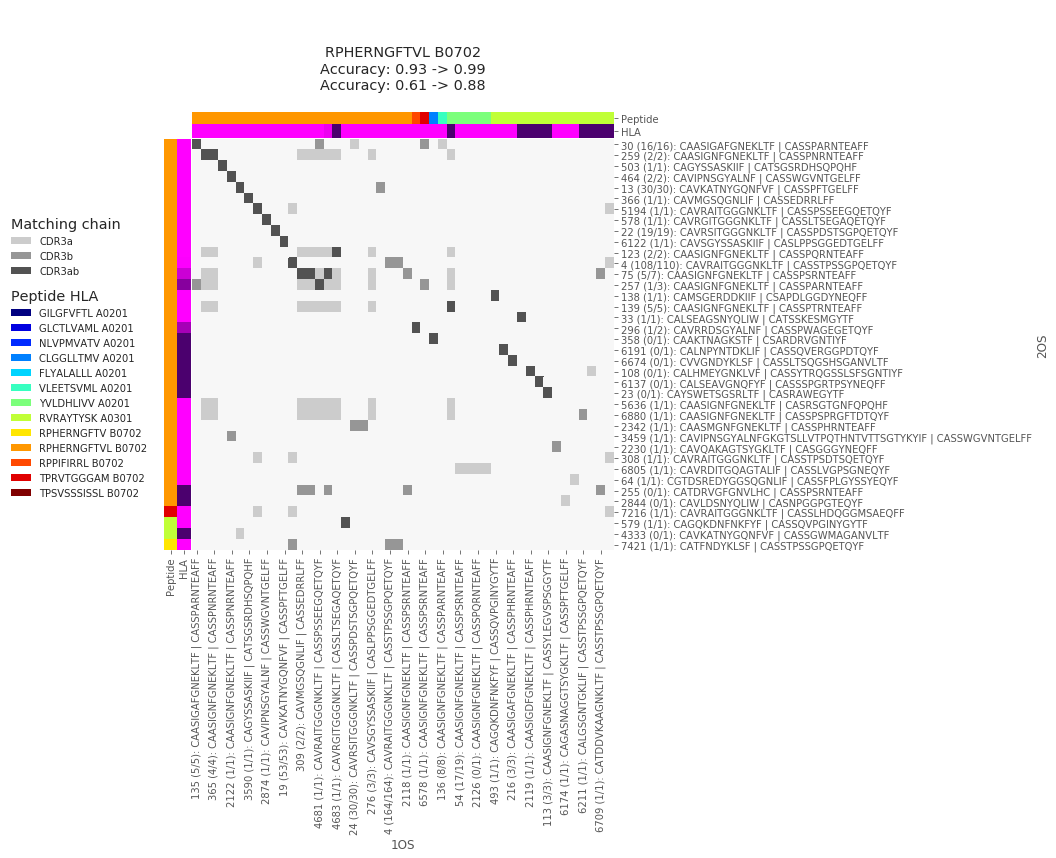

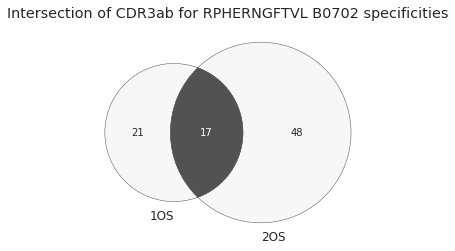

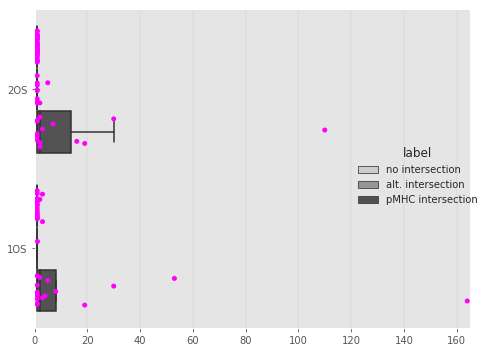

RPPIFIRRL B0702


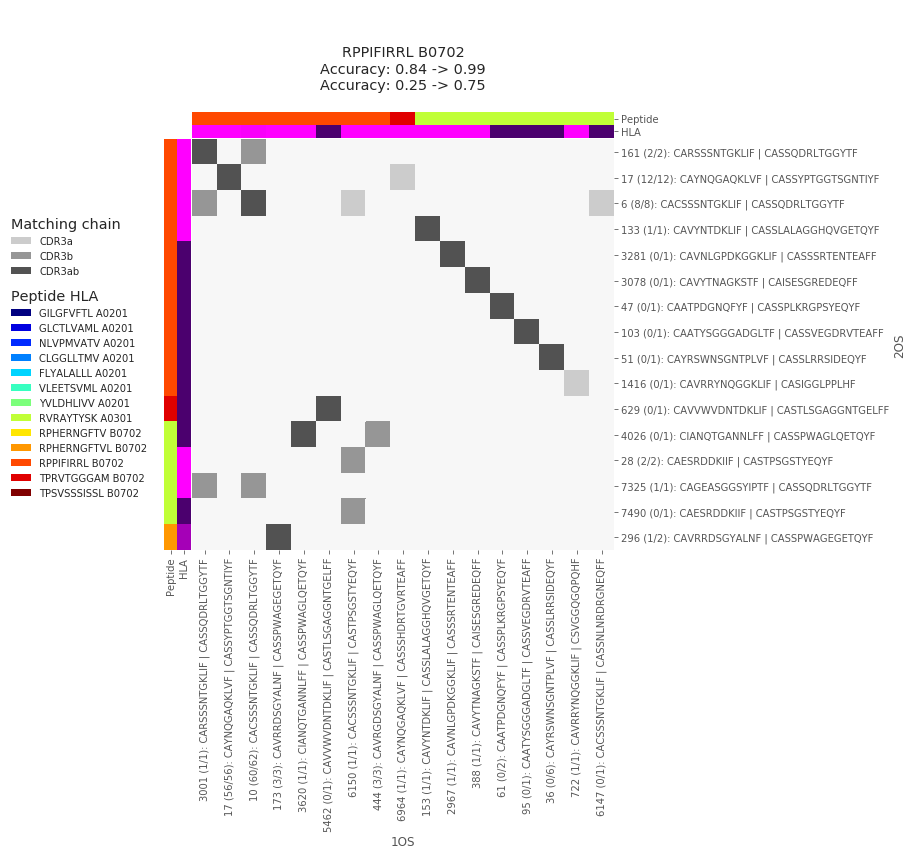

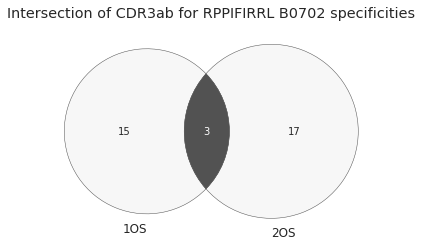

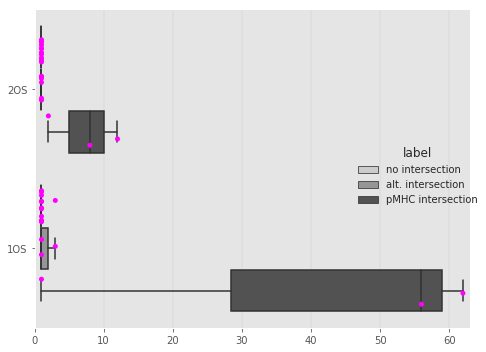

RVRAYTYSK A0301


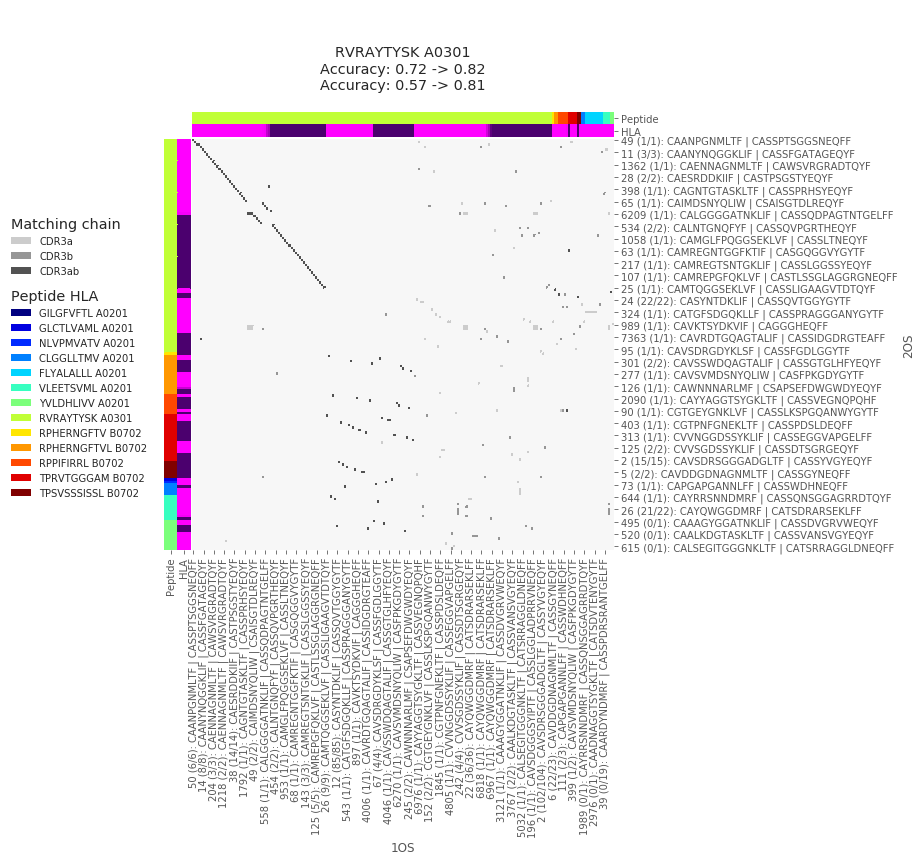

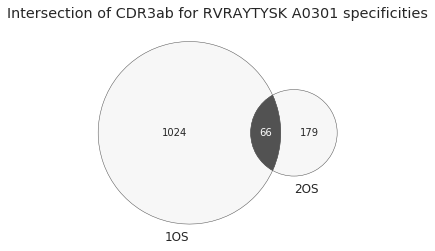

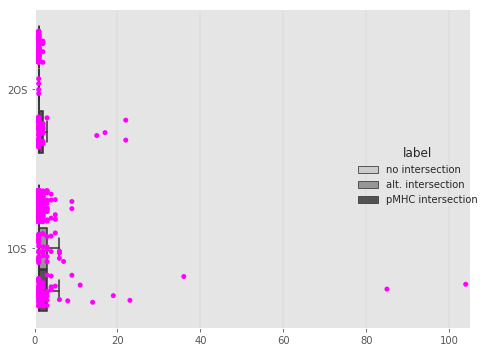

TPRVTGGGAM B0702


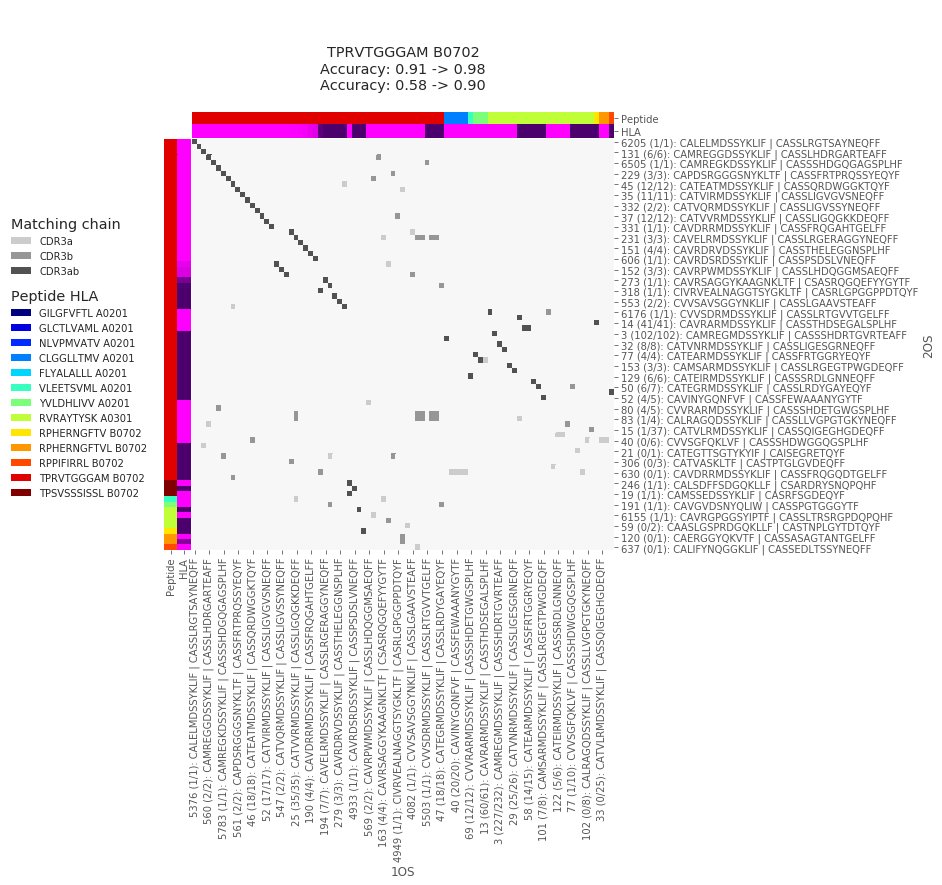

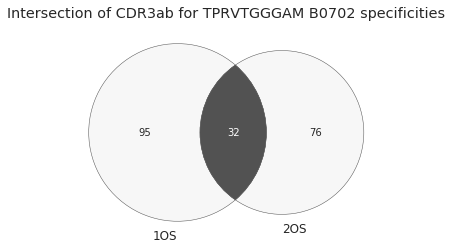

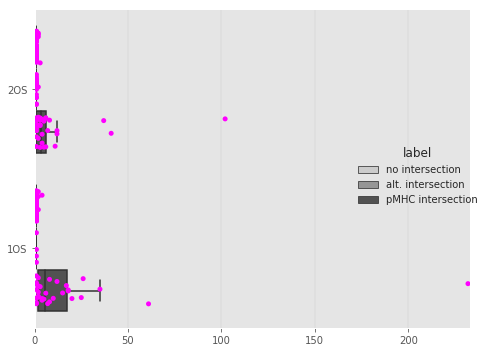

TPSVSSSISSL B0702


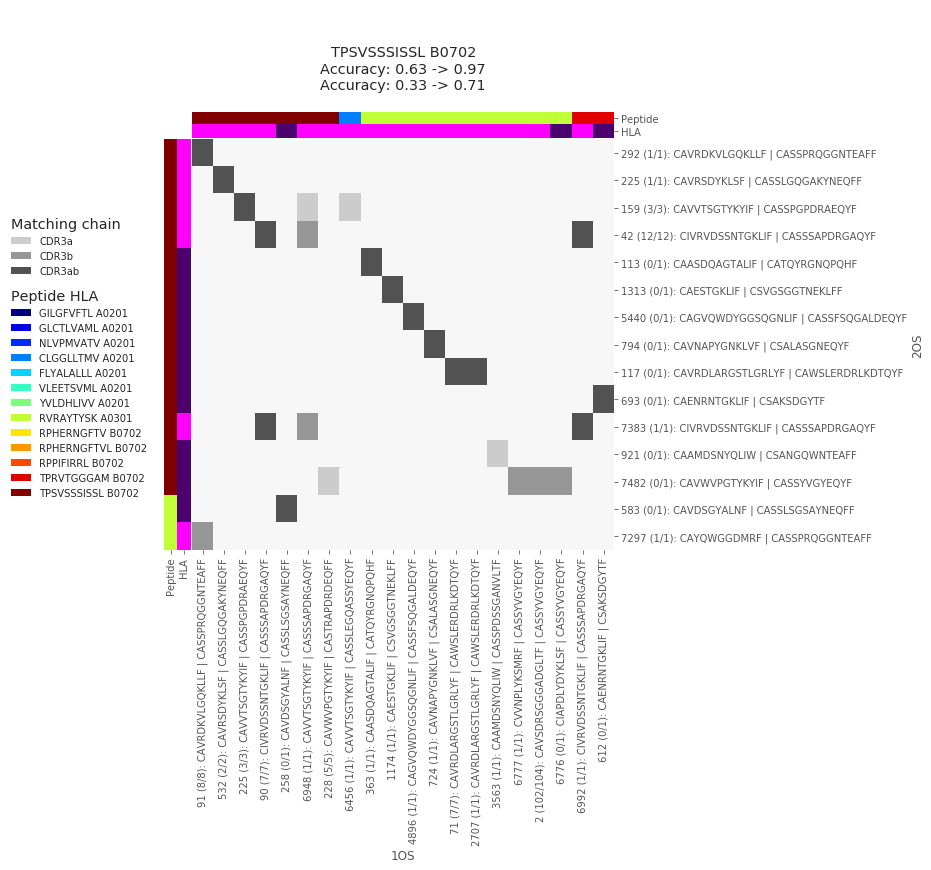

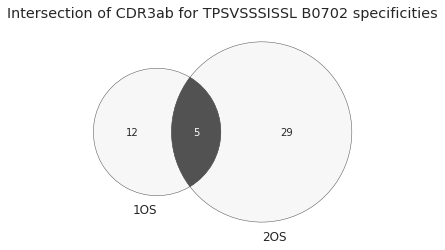

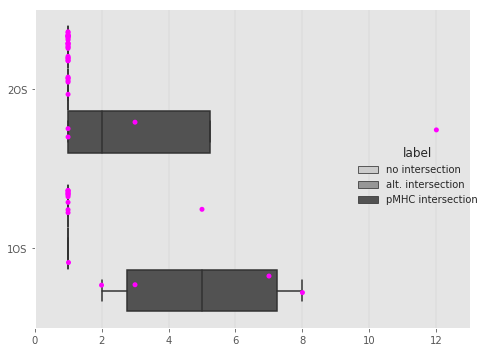

VLEETSVML A0201


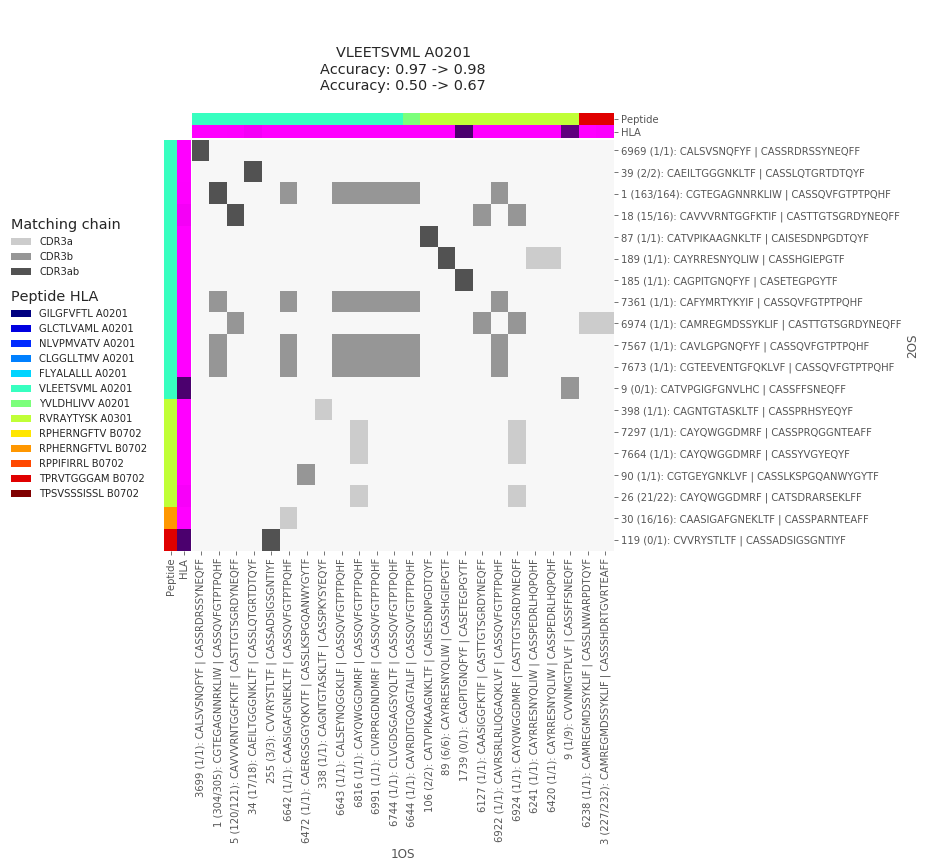

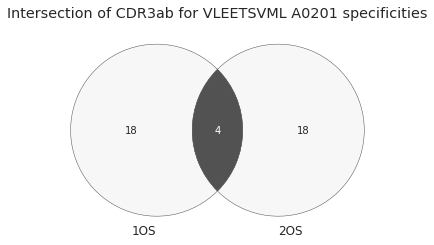

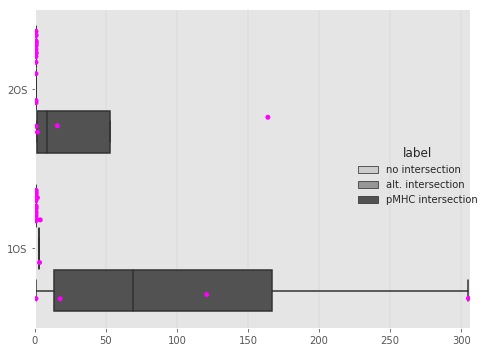

YVLDHLIVV A0201


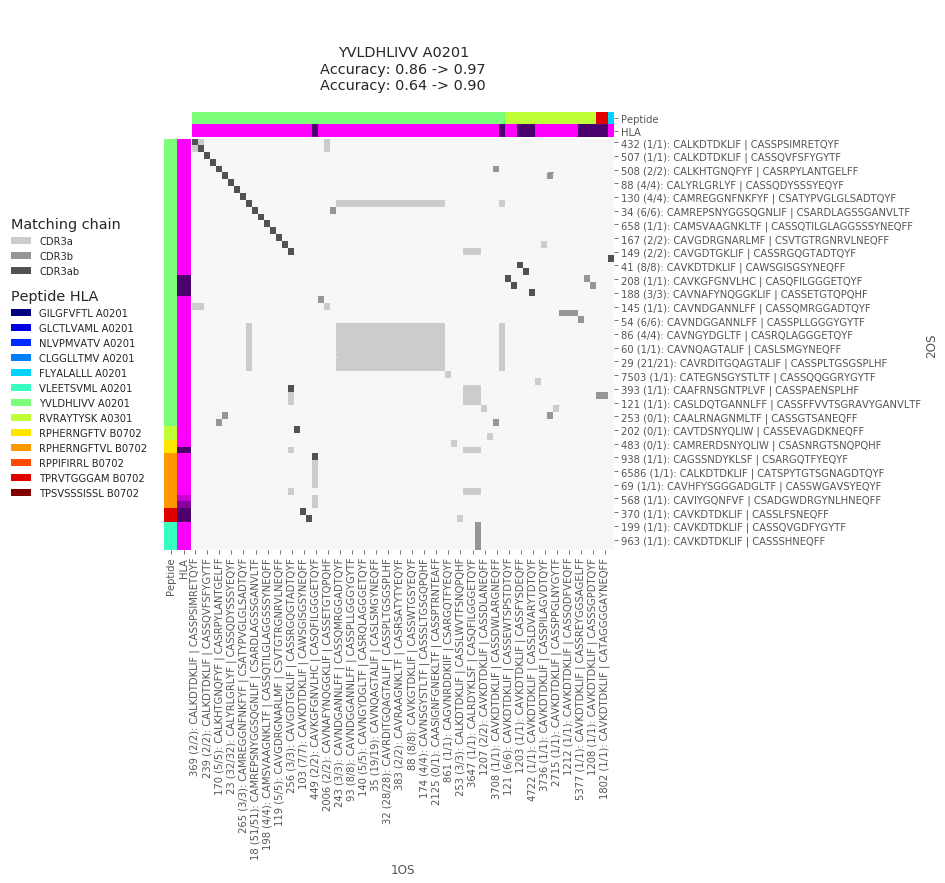

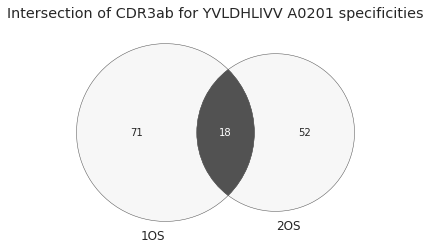

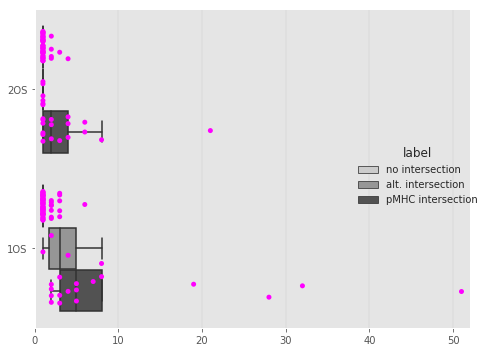

In [83]:
gem_dist = list()
for pep, grp_col in col_df.groupby('peptide_HLA'):
    print(pep)
    grp_row = row_df[row_df.peptide_HLA == pep]
    
    #col_cts = grp_col.ct.unique()
    #row_cts = grp_row.ct.unique()
    
    #tmp = mat_sum.loc[row_cts, col_cts].replace(0, np.nan).dropna(how='all', axis=0).dropna(how='all',axis=1)
    sim_1v2 = mat_sum.loc[row_df.ct.unique(), grp_col.ct.unique()].replace(0, np.nan).dropna(how='all', axis=0).dropna(how='all',axis=1).fillna(0)
    sim_2v1 = mat_sum.loc[grp_row.ct.unique(), col_df.ct.unique()].replace(0, np.nan).dropna(how='all', axis=0).dropna(how='all',axis=1).fillna(0)
    
    # All clonotypes selected for the heatmap
    row_cts = set(sim_1v2.index.to_list() + sim_2v1.index.to_list())
    col_cts = set(sim_1v2.columns.to_list() + sim_2v1.columns.to_list())
    
    # Find the cts with perfect matches
    pm1 = sim_1v2.where(sim_1v2 > 0.9).idxmax().dropna()
    pm2 = sim_2v1.where(sim_2v1 > 0.9).idxmax().dropna()
    pm = pd.concat([pm1,pm2]).to_frame().reset_index().rename(columns={'ct':'os1',0:'os2'}).drop_duplicates()
    
    row_tmp = pd.merge(row_df, pm, left_on='ct', right_on='os2', how='outer')
    col_tmp = pd.merge(col_df, pm, left_on='ct', right_on='os1', how='outer')
    
    # mark the perfect matches in row and col dfs to sort accordingly
    row_tmp['ctv'] = row_tmp.os1 #row_tmp.ct.map(pm.set_index('os2').os1)#.dropna()
    row_tmp['ct_match'] = np.where(row_tmp.ctv.isna(), 0, 1)
    row_tmp['HLA_match_count_v'] = row_tmp.ctv.map(col_df.set_index('ct').HLA_match_count)
    row_tmp['ct_pep_match_v'] = row_tmp.ctv.map(col_df.set_index('ct').peptide_HLA == pep)
    row_tmp['HLA_match_ratio_v'] = row_tmp.ctv.map(col_df.set_index('ct').HLA_match_ratio)
    
    col_tmp['ctv'] = col_tmp.os2 #col_tmp.ct.map(pm.set_index('os1').os2)#.dropna()
    col_tmp['ct_match'] = np.where(col_tmp.ctv.isna(), 0, 1)
    col_tmp['HLA_match_count_v'] = col_tmp.ctv.map(row_df.set_index('ct').HLA_match_count)
    col_tmp['ct_pep_match_v'] = col_tmp.ctv.map(row_df.set_index('ct').peptide_HLA == pep)
    col_tmp['HLA_match_ratio_v'] = col_tmp.ctv.map(row_df.set_index('ct').HLA_match_ratio)
    
    # Reset ranking of peptides
    rank = grp_row.epitope_rank.unique()[0] - 1
    diff = row_tmp.epitope_rank - rank
    row_tmp['tmp_rank'] = np.where(diff > 0, row_tmp.epitope_rank, diff+len(peptides)*10)
    diff = col_tmp.epitope_rank - rank
    col_tmp['tmp_rank'] = np.where(diff > 0, col_tmp.epitope_rank, diff+len(peptides)*10)
    
    row_tmp.sort_values(by=['tmp_rank','ct_match','ct_pep_match_v','HLA_match_ratio','HLA_match_ratio_v','cdr3_TRA','cdr3_TRB','HLA_match_count','HLA_match_count_v'],
                       ascending=[True, False, False, False, False, True, True, False, False], inplace=True)
    col_tmp.sort_values(by=['tmp_rank','ct_match','ct_pep_match_v','HLA_match_ratio','HLA_match_ratio_v','cdr3_TRA','cdr3_TRB','HLA_match_count','HLA_match_count_v'],
                       ascending=[True, False, False, False, False, True, True, False, False], inplace=True)
    
    row_tmp.drop_duplicates(subset=['ct'], inplace=True)
    col_tmp.drop_duplicates(subset=['ct'], inplace=True)
    
    if (len(row_cts)==0) & (len(col_cts)==0):
        continue

    row_colors = row_tmp[row_tmp.ct.isin(row_cts)].set_index('ct')[['col_pep','col_hla']].rename(columns={'col_pep':'Peptide','col_hla':'HLA'})
    col_colors = col_tmp[col_tmp.ct.isin(col_cts)].set_index('ct')[['col_pep','col_hla']].rename(columns={'col_pep':'Peptide','col_hla':'HLA'})
    
    row_labels = (row_tmp.loc[row_tmp.ct.isin(row_cts), 'ct'].astype(int).astype(str) + ' (' +
                  row_tmp.loc[row_tmp.ct.isin(row_cts), 'HLA_match_str'] + '): ' +
                  row_tmp.loc[row_tmp.ct.isin(row_cts), 'cdr3_TRA'] + ' | ' +
                  row_tmp.loc[row_tmp.ct.isin(row_cts), 'cdr3_TRB'])
    col_labels = (col_tmp.loc[col_tmp.ct.isin(col_cts), 'ct'].astype(int).astype(str) + ' (' +
                  col_tmp.loc[col_tmp.ct.isin(col_cts), 'HLA_match_str'] + '): ' +
                  col_tmp.loc[col_tmp.ct.isin(col_cts), 'cdr3_TRA'] + ' | ' +
                  col_tmp.loc[col_tmp.ct.isin(col_cts), 'cdr3_TRB'])
    
    # Extract data for plotting in the same order as the colors
    tmp = mat_sum.loc[row_colors.index, col_colors.index]#.replace(0, np.nan)#.dropna(how='all', axis=0).dropna(how='all',axis=1)
    
    # # highlight expected matches
    # exp_match_2os = grp_col[grp_col.HLA_match == 1].ct.unique()
    # exp_match_1os = grp_row[grp_row.HLA_match == 1].ct.unique()
    # tmp.loc[tmp.index.isin(exp_match_1os),tmp.columns.isin(exp_match_2os)].replace(0, np.nan, inplace=True)
    
    if tmp.empty:
        print('no intersection between the experiments')
        continue
        
    # For venn diagram & Accuracy
    #match_df = tmp.where(tmp > 0.9)
    os2_cts = row_df[row_df.peptide_HLA == pep].ct
    os1_cts = col_df[col_df.peptide_HLA == pep].ct
    complete_match = (tmp.loc[tmp.index.isin(os2_cts), tmp.columns.isin(os1_cts)] > 0.9).sum().sum()
    accuracy = complete_match / (tmp > 0.9).sum().sum()
    
    row_hla = row_df[row_df.HLA_match == 1].ct
    col_hla = col_df[col_df.HLA_match == 1].ct
    tmp_hla = tmp.loc[tmp.index.isin(row_hla), tmp.columns.isin(col_hla)]
    tmp_cpl = tmp.loc[tmp.index.isin(os2_cts) & tmp.index.isin(row_hla),
                      tmp.columns.isin(os1_cts) & tmp.columns.isin(col_hla)]
    accuracy_hla = (tmp_cpl > 0.9).sum().sum() / (tmp_hla > 0.9).sum().sum()
    
    acc_ct, acc_all, acc_ct_hla, acc_hla = compute_accuracy()
    
    # Plot heatmap
    ax = sns.clustermap(tmp, row_cluster=False, col_cluster=False, row_colors=row_colors, col_colors=col_colors, cmap=cmap, vmin=0, vmax=1)
    ax.cax.set_visible(False)
    ax.ax_heatmap.set_yticklabels(row_labels, rotation=0)
    ax.ax_heatmap.set_xticklabels(col_labels, rotation=90)
    ax.ax_heatmap.set_xlabel('1OS')
    ax.ax_heatmap.set_ylabel('2OS')
    ax.ax_heatmap.set_title('%s\nAccuracy: %.2f -> %.2f\nAccuracy: %.2f -> %.2f' %(pep, acc_all, acc_hla, acc_ct, acc_ct_hla), pad=50)
    
    #legend_sim = [mpatches.Patch(color=c, label=l) for c,l in zip(col_sim,['CDR3a','CDR3b','CDR3ab'])]
    #l_sim = ax.ax_heatmap.legend(loc='upper right', bbox_to_anchor=(-0.1,1.0), handles=legend_sim, frameon=False)
    #l_sim.set_title(title='Matching chain', prop={'size':10})
    
    for c,l in zip(col_sim,['CDR3a','CDR3b','CDR3ab']):
        ax.ax_col_dendrogram.bar(0, 0, color=c, label=l, linewidth=0);
    l_sim = ax.ax_col_dendrogram.legend(title='Matching chain',title_fontsize='x-large', loc='upper left', bbox_to_anchor=(0.05,0.6), bbox_transform=gcf().transFigure, frameon=False)
    l_sim._legend_box.align = "left"
    
    #legend_pep = [mpatches.Patch(color=c, label=l) for c,l in row_df.loc[row_df.ct.isin(tmp.index),['col_pep','peptide_HLA']].drop_duplicates().values]
    #l_pep = ax.ax_heatmap.legend(loc='upper right', bbox_to_anchor=(-0.1,0.5), handles=legend_pep, frameon=False)
    #l_pep.set_title(title='Peptide HLA', prop={'size':10})
    
    #for c,l in row_df.loc[row_df.ct.isin(tmp.index),['col_pep','peptide_HLA']].drop_duplicates().values:
    for c,l in row_df[['col_pep','peptide_HLA']].drop_duplicates().values:
        ax.ax_row_dendrogram.bar(0, 0, color=c, label=l, linewidth=0);
    l_pep = ax.ax_row_dendrogram.legend(title='Peptide HLA',title_fontsize='x-large', loc='upper left', bbox_to_anchor=(0.05,0.5), bbox_transform=gcf().transFigure, frameon=False)
    l_pep._legend_box.align = "left"
    
    plt.show()
    
    c = venn2(subsets=(len(os1_cts)-complete_match, len(os2_cts)-complete_match, complete_match),
              set_labels=('1OS','2OS'))
    c.get_patch_by_id('10').set_color('#f7f7f7')
    c.get_patch_by_id('10').set_edgecolor('#525252')
    c.get_patch_by_id('10').set_alpha(1)
    c.get_patch_by_id('01').set_color('#f7f7f7')
    c.get_patch_by_id('01').set_edgecolor('#525252')
    c.get_patch_by_id('01').set_alpha(1)
    
    if complete_match > 0:
        c.get_patch_by_id('11').set_color('#525252')
        c.get_patch_by_id('11').set_edgecolor('#525252')
        c.get_patch_by_id('11').set_alpha(1)
        c.get_label_by_id('11').set_color('white')
    plt.title(f'Intersection of CDR3ab for {pep} specificities')
    plt.show()
    
    gem_dist.append(plot_gem_distribution())
    
    #if pep == 'RPHERNGFTVL B0702':
    #    break
    
    i = (tmp.loc[~tmp.index.isin(grp_row.ct) & tmp.index.isin(row_hla),
                 tmp.columns.isin(grp_col.ct) & tmp.columns.isin(col_hla)] > 0.9).replace(False, np.nan).dropna(how='all',axis=0).dropna(how='all',axis=1)
    j = (tmp.loc[tmp.index.isin(grp_row.ct) & tmp.index.isin(row_hla),
                 ~tmp.columns.isin(grp_col.ct) & tmp.columns.isin(col_hla)] > 0.9).replace(False, np.nan).dropna(how='all',axis=0).dropna(how='all',axis=1)
    
    i_2os = i.index.to_list() + j.index.to_list()
    i_1os = i.columns.to_list() + j.columns.to_list()
    
    if i.empty & j.empty:
        continue
    
    #print('2OS')
    #print(os2.loc[os2.ct.isin(i_2os),cols].sort_values(by=['ct','peptide_HLA']))
    #print('---------------------------------------------------------------------------------------------------------------')
    #print('1OS')
    #print(os1.loc[os1.ct.isin(i_1os),cols].sort_values(by=['ct','peptide_HLA']))
    
    

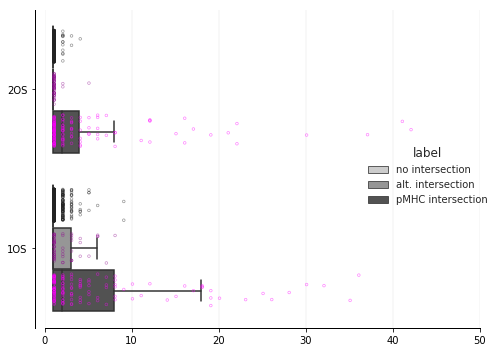

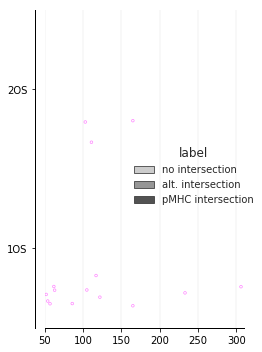

In [126]:
sns.set_style('ticks', {'axes.edgecolor': '0',  
                        'xtick.color': '0',
                        'ytick.color': '0'})

compiled_gem_dist = pd.concat(gem_dist)

labels = ('no intersection', 'alt. intersection', 'pMHC intersection')

g = sns.catplot(data=compiled_gem_dist, x='n_gems', y='os', hue='label', kind='box', palette=col_sim, fliersize=0, hue_order=labels) #palette=col_sim
g.map_dataframe(sns.stripplot,x='n_gems', y='os', hue='label', hue_order=labels, dodge=True, alpha=0.5, color='magenta' ,marker="$\circ$", lw=20, jitter=0.3) #palette=color
for ax in g.axes.flatten():
    #ax.tick_params(axis='y', which='both', direction='out', length=4, left=True)
    ax.grid(b=True, which='both', axis='x', color='gray', linewidth=0.1)
    ax.set_xlim(0,50)
    #ax.set_xlim(0,compiled_gem_dist.n_gems.max()+5)
sns.despine(offset={'left':10})
plt.show()

g = sns.catplot(data=compiled_gem_dist, x='n_gems', y='os', hue='label', kind='box', palette=col_sim, fliersize=0, hue_order=labels, aspect=0.35) #palette=col_sim
g.map_dataframe(sns.stripplot,x='n_gems', y='os', hue='label', hue_order=labels, dodge=True, alpha=0.5, color='magenta' ,marker="$\circ$", lw=20, jitter=0.3) #palette=color
for ax in g.axes.flatten():
    #ax.tick_params(axis='y', which='both', direction='out', length=4, left=True)
    ax.grid(b=True, which='both', axis='x', color='gray', linewidth=0.1)
    #ax.set_xlim(0,50)
    ax.set_xlim(50,compiled_gem_dist.n_gems.max()+5)
sns.despine(offset={'left':10})
plt.show()


In [236]:
from matplotlib_venn import venn3, venn3_circles, venn3_unweighted

In [200]:
b_1os = set(pm1.index) - set(pm2.index)
b_1os

{150.0, 7025.0}

In [204]:
c_1os = set(pm1.index).intersection(set(pm2.index))

In [201]:
b_2os = set(pm2.values) - set(pm1.values)
b_2os

{143.0, 157.0}

In [205]:
c_2os = set(pm2.values).intersection(set(pm1.values))

In [252]:
a_2os = set(row_df[row_df.peptide_HLA == pep].ct) - b_2os - c_2os
a_1os = set(col_df[col_df.peptide_HLA == pep].ct) - b_1os - c_1os

/home/people/herpov/.conda/envs/snakemake/lib/python3.7/site-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")


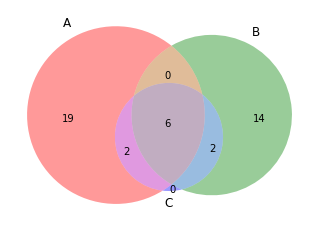

In [222]:
Abc = len(a_1os)
aBc = len(a_2os)
ABc = 0
abC = 0
AbC = len(b_1os)
aBC = len(b_2os)
ABC = len(c_1os)

v = venn3(subsets=(Abc, aBc, ABc, abC, AbC, aBC, ABC))
plt.show()

In [259]:
tmp = col_df.loc[col_df.ct.isin(b_1os), ['n_gems','HLA_match_ratio']]
tmp['label'] = '1OS alt. pMHC'
tmp

n_gems  HLA_match_ratio          label
167        2              1.0  1OS alt. pMHC
2334       1              1.0  1OS alt. pMHC

In [261]:
tmp = col_df.loc[col_df.ct.isin(a_1os), ['n_gems','HLA_match_ratio']]
tmp['label'] = '1OS no intersection'
tmp

n_gems  HLA_match_ratio                label
327        2              1.0  1OS no intersection
1471       1              1.0  1OS no intersection
379        1              1.0  1OS no intersection
2014       1              1.0  1OS no intersection
2165       1              1.0  1OS no intersection
1904       1              1.0  1OS no intersection
2143       1              1.0  1OS no intersection
148        1              1.0  1OS no intersection
2167       1              1.0  1OS no intersection
2283       1              1.0  1OS no intersection
1101       1              1.0  1OS no intersection
2168       1              1.0  1OS no intersection
2169       1              1.0  1OS no intersection
2170       1              1.0  1OS no intersection
797        1              1.0  1OS no intersection
1041       1              1.0  1OS no intersection
1634       1              1.0  1OS no intersection
549        1              0.0  1OS no intersection
1142       1              0.0  1OS no intersection

In [262]:
tmp = col_df.loc[col_df.ct.isin(c_1os), ['n_gems','HLA_match_ratio']]
tmp['label'] = '1OS intersection'
tmp

n_gems  HLA_match_ratio             label
18       116         0.991379  1OS intersection
129        7         1.000000  1OS intersection
130        6         1.000000  1OS intersection
2166       1         1.000000  1OS intersection
1106       1         1.000000  1OS intersection
84        10         0.000000  1OS intersection

In [274]:
dfs = list()
for os, df, sets in [('2OS', row_df, (a_2os, b_2os, c_2os)), ('1OS', col_df, (a_1os, b_1os, c_1os))]:
    for s,l in zip(sets, ('no intersection', 'alt. intersection', 'pMHC intersection')):
        tmp = df.loc[df.ct.isin(s), ['n_gems','HLA_match_ratio']]
        tmp['label'] = l
        tmp['os'] = os
        dfs.append(tmp)

In [275]:
plt_df = pd.concat(dfs)

In [291]:
plt_df

n_gems  HLA_match_ratio              label   os
897        1         1.000000    no intersection  2OS
637        1         1.000000    no intersection  2OS
870        1         1.000000    no intersection  2OS
541        1         1.000000    no intersection  2OS
871        1         1.000000    no intersection  2OS
668        1         1.000000    no intersection  2OS
135        1         1.000000  alt. intersection  2OS
126        1         0.000000  alt. intersection  2OS
13        42         1.000000  pMHC intersection  2OS
75         5         1.000000  pMHC intersection  2OS
113        4         1.000000  pMHC intersection  2OS
677        2         1.000000  pMHC intersection  2OS
193        1         1.000000  pMHC intersection  2OS
73         1         0.000000  pMHC intersection  2OS
327        2         1.000000    no intersection  1OS
1471       1         1.000000    no intersection  1OS
379        1         1.000000    no intersection  1OS
2014       1         1.000000    no intersection  1OS
2165       1         1.000000    no intersection  1OS
1904       1         1.000000    no intersection  1OS
2143       1         1.000000    no intersection  1OS
148        1         1.000000    no intersection  1OS
2167       1         1.000000    no intersection  1OS
2283       1         1.000000    no intersection  1OS
1101       1         1.000000    no intersection  1OS
2168       1         1.000000    no intersection  1OS
2169       1         1.000000    no intersection  1OS
2170       1         1.000000    no intersection  1OS
797        1         1.000000    no intersection  1OS
1041       1         1.000000    no intersection  1OS
1634       1         1.000000    no intersection  1OS
549        1         0.000000    no intersection  1OS
1142       1         0.000000    no intersection  1OS
167        2         1.000000  alt. intersection  1OS
2334       1         1.000000  alt. intersection  1OS
18       116         0.991379  pMHC intersection  1OS
129        7         1.000000  pMHC intersection  1OS
130        6         1.000000  pMHC intersection  1OS
2166       1         1.000000  pMHC intersection  1OS
1106       1         1.000000  pMHC intersection  1OS
84        10         0.000000  pMHC intersection  1OS

AttributeError: 'numpy.ndarray' object has no attribute 'set_title'

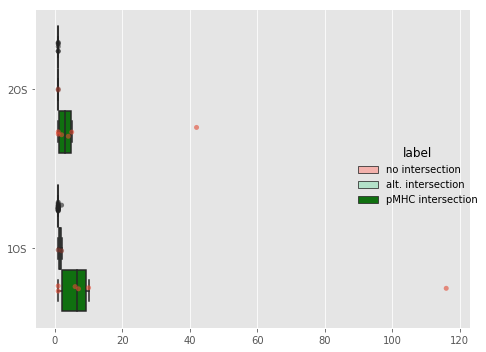

In [286]:
g = sns.catplot(data=plt_df, x='n_gems', y='os', hue='label', kind='box', palette=["#FFA7A0", "#ABEAC9","green"], fliersize=0)
g.map_dataframe(sns.stripplot,x='n_gems', y='os', hue='label', dodge=True, alpha=0.6)

In [182]:
row_df.sort_values(by=['epitope_rank','peptide_HLA','HLA_match_ratio','HLA_match_count'], ascending=[True, True, False, False], inplace=True)
col_df.sort_values(by=['epitope_rank','peptide_HLA','HLA_match_ratio','HLA_match_count'], ascending=[True, True, False, False], inplace=True)

<Figure size 1440x1440 with 0 Axes>

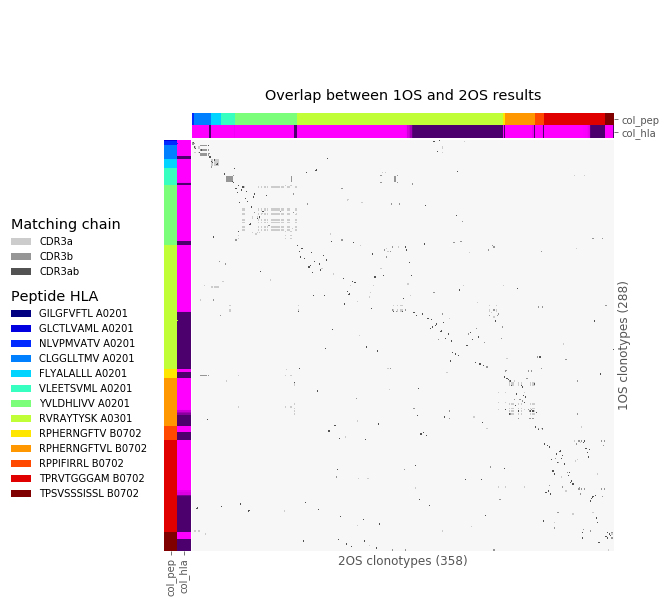

In [183]:
tmp = mat_sum.replace(0, np.nan).dropna(how='all', axis=0).dropna(how='all',axis=1).fillna(0)

row_colors = row_df[row_df.ct.isin(tmp.index)].set_index('ct')[['col_pep','col_hla']]
col_colors = col_df[col_df.ct.isin(tmp.columns)].set_index('ct')[['col_pep','col_hla']]

plt.figure(figsize=(20,20))
ax = sns.clustermap(tmp, row_cluster=False, col_cluster=False, cmap=cmap, row_colors=row_colors, col_colors=col_colors,vmin=0,vmax=1)
ax.cax.set_visible(False)
ax.ax_heatmap.set_xticks([],[])
ax.ax_heatmap.set_yticks([],[])
ax.ax_heatmap.set_xlabel('2OS clonotypes (%d)' %len(tmp.columns))
ax.ax_heatmap.set_ylabel('1OS clonotypes (%d)' %len(tmp.index))
ax.ax_heatmap.set_title('Overlap between 1OS and 2OS results', pad=40)

for c,l in zip(col_sim,['CDR3a','CDR3b','CDR3ab']):
    ax.ax_col_dendrogram.bar(0, 0, color=c, label=l, linewidth=0);
l_sim = ax.ax_col_dendrogram.legend(title='Matching chain',title_fontsize='x-large', loc='upper left', bbox_to_anchor=(0.05,0.6), bbox_transform=gcf().transFigure, frameon=False)
l_sim._legend_box.align = "left"

for c,l in row_df[['col_pep','peptide_HLA']].drop_duplicates().values:
    ax.ax_row_dendrogram.bar(0, 0, color=c, label=l, linewidth=0);
l_pep = ax.ax_row_dendrogram.legend(title='Peptide HLA',title_fontsize='x-large', loc='upper left', bbox_to_anchor=(0.05,0.5), bbox_transform=gcf().transFigure, frameon=False)
l_pep._legend_box.align = "left"

plt.show()

In [187]:
(tmp > 0.9).sum().sum()

219

In [184]:
sns.clustermap(mat_sum, method='ward', row_cluster=True, col_cluster=True, row_colors=row_colors, cmap="vlag", vmin=1, vmax=2)

KeyError: '[243.0, 1008.0, 6216.0, 969.0, 974.0, 5333.0, 58.0, 504.0, 5321.0, 3383.0, 4598.0, 5105.0, 7489.0, 459.0, 3279.0, 3390.0, 4296.0, 777.0, 1513.0, 2093.0, 5203.0, 5538.0, 6168.0, 6504.0, 6920.0, 7739.0, 2134.0, 142.0, 218.0, 176.0, 239.0, 297.0, 170.0, 337.0, 406.0, 566.0, 574.0, 986.0, 1334.0, 1961.0, 2082.0, 3118.0, 3127.0, 3254.0, 3433.0, 4231.0, 4241.0, 4451.0, 4622.0, 5211.0, 5521.0, 5527.0, 7616.0, 1341.0, 2269.0, 323.0, 128.0, 201.0, 204.0, 307.0, 380.0, 382.0, 418.0, 441.0, 458.0, 496.0, 505.0, 560.0, 624.0, 933.0, 954.0, 985.0, 1020.0, 1363.0, 1415.0, 1435.0, 1490.0, 2025.0, 2026.0, 2039.0, 2243.0, 2278.0, 2880.0, 2922.0, 3047.0, 3058.0, 3089.0, 3113.0, 3136.0, 3185.0, 3187.0, 3277.0, 3306.0, 3381.0, 3402.0, 3430.0, 4025.0, 4131.0, 4173.0, 4360.0, 4392.0, 4400.0, 4428.0, 4575.0, 4627.0, 4659.0, 5098.0, 5236.0, 5268.0, 5270.0, 5416.0, 5487.0, 5537.0, 5950.0, 6108.0, 6177.0, 6178.0, 6224.0, 6242.0, 6246.0, 6399.0, 6454.0, 6494.0, 6605.0, 6677.0, 6756.0, 7491.0, 469.0, 61.0, 101.0, 111.0, 165.0, 303.0, 341.0, 378.0, 381.0, 486.0, 492.0, 512.0, 584.0, 592.0, 625.0, 645.0, 800.0, 801.0, 805.0, 956.0, 1307.0, 1354.0, 1425.0, 1433.0, 1495.0, 1512.0, 1917.0, 1924.0, 2016.0, 2051.0, 2055.0, 2147.0, 2170.0, 2222.0, 2985.0, 3032.0, 3091.0, 3134.0, 3197.0, 3273.0, 3346.0, 3382.0, 3409.0, 3416.0, 3441.0, 3988.0, 4085.0, 4116.0, 4163.0, 4242.0, 4246.0, 4277.0, 4316.0, 4340.0, 4481.0, 4517.0, 4608.0, 4651.0, 4652.0, 5225.0, 5302.0, 5408.0, 5447.0, 5449.0, 5498.0, 5544.0, 5548.0, 5578.0, 5582.0, 5966.0, 5979.0, 6051.0, 6104.0, 6129.0, 6253.0, 6409.0, 6412.0, 6457.0, 6477.0, 6497.0, 6590.0, 6698.0, 6718.0, 7022.0, 7040.0, 7643.0, 4038.0, 4603.0, 1059.0, 1350.0, 2197.0, 4094.0, 5249.0, 5461.0, 6208.0, 106.0, 250.0, 293.0, 445.0, 604.0, 1288.0, 2149.0, 2186.0, 3133.0, 3146.0, 3299.0, 4528.0, 4548.0, 5127.0, 5183.0, 6054.0, 310.0, 465.0, 561.0, 775.0, 1001.0, 1856.0, 1920.0, 2181.0, 2949.0, 3056.0, 3278.0, 5132.0, 5297.0, 5398.0, 6939.0, 215.0, 278.0, 1326.0, 5399.0, 5415.0, 6716.0, 576.0, 649.0, 1903.0, 2089.0, 600.0, 94.0, 530.0, 628.0, 1303.0, 2310.0, 3044.0, 4540.0, 4581.0, 5422.0, 6048.0, 6206.0, 6420.0, 6451.0, 7219.0, 245.0, 279.0, 334.0, 340.0, 349.0, 558.0, 659.0, 798.0, 960.0, 1967.0, 2115.0, 2164.0, 2198.0, 2285.0, 2991.0, 3068.0, 4401.0, 4515.0, 5191.0, 5420.0, 5438.0, 5547.0, 5614.0, 5954.0, 6410.0, 6584.0, 6699.0, 6842.0, 7506.0, 179.0, 536.0, 1443.0, 1467.0, 3186.0, 4215.0, 5189.0, 6669.0, 488.0, 784.0, 1960.0, 2018.0, 3198.0, 4127.0, 4372.0, 5250.0, 5550.0, 5612.0, 6621.0, 7414.0, 7562.0] not in index'

<Figure size 720x720 with 0 Axes>

In [37]:
os2 = row_df.copy()

In [40]:
df2 = df.copy()

In [71]:
os1 = row_df.copy()

In [72]:
df1 = df.copy()

In [73]:
os1

ct           cdr3_TRA             cdr3_TRB  binding_concordance  \
645   1242.0  CAFSLSAGGTSYGKLTF         CASSIGVYGYTF                  1.0   
852   1944.0    CVVPKEDSSASKIIF        CASSIFHTGELFF                  1.0   
535    883.0        CAEDNNARLMF        CSARDGTGNGYTF                  1.0   
615   1177.0         CAVSTGKLIF       CSVGTGGTNEKLFF                  1.0   
1377  3697.0        CALYNTDKLIF      CASSPTSGSVYEQYF                  1.0   
...      ...                ...                  ...                  ...   
1194  3016.0     CALKRRGNTGKLIF     CSARDGARGNTGELFF                  1.0   
2003  5861.0      CAVTPSGNTPLVF  CASSQHYPSGMGNTGELFF                  1.0   
2017  5902.0   CAMREIQVRNNARLMF  CASSQHYPSGMGNTGELFF                  1.0   
2124  6269.0      CALSEARGDKIIF          CASESPEGAFF                  1.0   
2315  6948.0      CAVVTSGTYKYIF       CASSSAPDRGAQYF                  1.0   

            peptide_HLA  epitope_rank HLA_mhc  col_pep  col_hla  
645     GILGFVFTL A0201           1.0   A0201  #800000  #000080  
852     GILGFVFTL A0201           1.0   A0201  #800000  #000080  
535     GLCTLVAML A0201           2.0   A0201  #e00000  #000080  
615     GLCTLVAML A0201           2.0   A0201  #e00000  #000080  
1377    GLCTLVAML A0201           2.0   A0201  #e00000  #000080  
...                 ...           ...     ...      ...      ...  
1194  TPSVSSSISSL B0702           6.0   B0702  #ffe600  #800000  
2003  TPSVSSSISSL B0702           6.0   B0702  #ffe600  #800000  
2017  TPSVSSSISSL B0702           6.0   B0702  #ffe600  #800000  
2124  TPSVSSSISSL B0702           6.0   B0702  #ffe600  #800000  
2315  TPSVSSSISSL B0702           6.0   B0702  #ffe600  #800000  

[1471 rows x 9 columns]

In [74]:
os2

ct         cdr3_TRA              cdr3_TRB  binding_concordance  \
184   243.0     CAVDDYGQNFVF          CAIRELAGEQFF                  1.0   
336  1008.0   CAALEFPNDYKLSF         CSANRGDPREQFF                  1.0   
779  6216.0  CASRYSGAGSYQLTF     CASSSPFRTGITDTQYF                  1.0   
146   172.0       CAVSGGKLTF      CASSLAPSGSWYEQFF                  1.0   
330   969.0      CAHDNNARLMF         CSARDGVGNGYTF                  1.0   
..      ...              ...                   ...                  ...   
828  6669.0      CAVAGNTPLVF  CASSLTPRRTGGPGANVLTF                  1.0   
885  7383.0  CIVRVDSSNTGKLIF        CASSSAPDRGAQYF                  1.0   
888  7414.0    CAVRDLGRDKIIF       CASSSTPGGGNEQFF                  1.0   
896  7482.0    CAVWVPGTYKYIF          CASSYVGYEQYF                  1.0   
906  7562.0    CAVKENGGFKTIF     CASSPVGGGPPLDEQFF                  1.0   

           peptide_HLA  epitope_rank HLA_mhc  col_pep  col_hla  
184    GILGFVFTL A0201           1.0   A0201  #e00000  #000080  
336    GILGFVFTL A0201           1.0   A0201  #e00000  #000080  
779    GILGFVFTL A0201           1.0   A0201  #e00000  #000080  
146    GLCTLVAML A0201           2.0   A0201  #ff4800  #000080  
330    GLCTLVAML A0201           2.0   A0201  #ff4800  #000080  
..                 ...           ...     ...      ...      ...  
828  TPSVSSSISSL B0702           8.0   B0702  #c0ff37  #800000  
885  TPSVSSSISSL B0702           8.0   B0702  #c0ff37  #800000  
888  TPSVSSSISSL B0702           8.0   B0702  #c0ff37  #800000  
896  TPSVSSSISSL B0702           8.0   B0702  #c0ff37  #800000  
906  TPSVSSSISSL B0702           8.0   B0702  #c0ff37  #800000  

[616 rows x 9 columns]

In [200]:
# Attempt to define super clonotypes with identical CDR3 sequences. Not succeeded.
lol = df1.groupby(['ct','cdr3_TRA','cdr3_TRB']).size().to_frame().reset_index().drop_duplicates(subset='ct', keep='last').rename(columns={0:'ct_freq'})

In [204]:
lol.sort_values(by='ct_freq', ascending=False, inplace=True)
lol.drop_duplicates(subset=['cdr3_TRA','cdr3_TRB'], inplace=True)
lol.reset_index(drop=True, inplace=True)
lol.reset_index(inplace=True)
lol.rename(columns={'index':'ct_super'}, inplace=True)
lol.ct_super = lol.ct_super + 1
dct = lol.set_index(['cdr3_TRA','cdr3_TRB']).ct_super


In [210]:
df1['ct_super'] = df1.fillna('').set_index(['cdr3_TRA','cdr3_TRB']).index.map(dct)

In [90]:
os1.sort_values(by=['cdr3_TRA','cdr3_TRB','ct'])

ct         cdr3_TRA            cdr3_TRB  binding_concordance  \
410    526.0      CAAAGNTPLVF     CASSTRDRGFYGYTF                  1.0   
1220  3121.0  CAAAGYGGATNKLIF      CASSDVGRVWEQYF                  1.0   
2006  5876.0    CAAALYNNNDMRF  CASSLEKGDRVLGDTQYF                  1.0   
533    870.0       CAAANNDMRF       CSARTSGRHEQYF                  1.0   
1370  3675.0      CAAARGARLMF      CASSLRQGTDTQYF                  1.0   
...      ...              ...                 ...                  ...   
1503  4049.0   CVVSSMDSNYQLIW     CASSLSPGVDQPQHF                  1.0   
1187  2999.0   CVVSVWGGYQKVTF      CASHPGTDYNEQFF                  1.0   
497    731.0   CVVTAPSGTYKYIF        CSADRVRLEQFF                  1.0   
189    177.0  CVVTHSGGGADGLTF      CASSPAGITTGGYF                  0.5   
1683  4787.0    CVVWGGFGNVLHC    CASSQAGTREYNEQFF                  1.0   

          peptide_HLA  epitope_rank HLA_mhc  col_pep  col_hla  
410   RVRAYTYSK A0301           5.0   A0301  #0000e0  #7bff7b  
1220  RVRAYTYSK A0301           5.0   A0301  #0000e0  #7bff7b  
2006  RVRAYTYSK A0301           5.0   A0301  #0000e0  #7bff7b  
533   RVRAYTYSK A0301           5.0   A0301  #0000e0  #7bff7b  
1370  RVRAYTYSK A0301           5.0   A0301  #0000e0  #7bff7b  
...               ...           ...     ...      ...      ...  
1503  RVRAYTYSK A0301           5.0   A0301  #0000e0  #7bff7b  
1187  RVRAYTYSK A0301           5.0   A0301  #0000e0  #7bff7b  
497   RVRAYTYSK A0301           5.0   A0301  #0000e0  #7bff7b  
189   RVRAYTYSK A0301           5.0   A0301  #0000e0  #7bff7b  
1683  RVRAYTYSK A0301           5.0   A0301  #0000e0  #7bff7b  

[1471 rows x 9 columns]

In [81]:
os1[os1.duplicated(subset=['cdr3_TRA','cdr3_TRB'], keep=False)]

ct           cdr3_TRA           cdr3_TRB  binding_concordance  \
2167  6453.0        CAVDNFNKFYF   CASSLEGQASSYEQYF             1.000000   
2283  6840.0        CAVDNFNKFYF   CASSLEGQASSYEQYF             1.000000   
394    501.0         CAAGSYQLTF    CASSGDSETYNEQFF             1.000000   
1117  2827.0         CAAGSYQLTF    CASSGDSETYNEQFF             1.000000   
42      22.0        CAYQWGGDMRF     CATSDRARSEKLFF             1.000000   
90      71.0  CAVRDLARGSTLGRLYF   CAWSLERDRLKDTQYF             1.000000   
98      81.0           CGRGKLTF     CASSWGAVSYEQYF             0.833333   
210    204.0       CAENNAGNMLTF     CAWSVRGRADTQYF             1.000000   
212    207.0     CLVGHNNAGNMLTF      CATSEDSNQPQHF             1.000000   
214    208.0     CLVGHNNAGNMLTF      CATSEDSNQPQHF             1.000000   
337    399.0     CAVSVMDSNYQLIW      CASFPKGDYGYTF             1.000000   
623   1193.0       CVVNMGGNQFYF     CAWKPPGDQETQYF             1.000000   
624   1194.0       CVVNMGGNQFYF     CAWKPPGDQETQYF             1.000000   
637   1218.0       CAENNAGNMLTF     CAWSVRGRADTQYF             1.000000   
1085  2707.0  CAVRDLARGSTLGRLYF   CAWSLERDRLKDTQYF             1.000000   
1159  2936.0     CAVRGPGGSYIPTF  CASSLTRSRGPDQPQHF             1.000000   
1886  5483.0     CAVRGPGGSYIPTF  CASSLTRSRGPDQPQHF             1.000000   
2121  6241.0      CAYRRESNYQLIW    CASSPEDRLHQPQHF             1.000000   
2125  6270.0     CAVSVMDSNYQLIW      CASFPKGDYGYTF             1.000000   
2158  6420.0      CAYRRESNYQLIW    CASSPEDRLHQPQHF             1.000000   
2262  6773.0           CGRGKLTF     CASSWGAVSYEQYF             1.000000   
2270  6800.0  CATDGGPRSGTASKLTF  CASSLFGLAESTDTQYF             1.000000   
2279  6818.0        CAYQWGGDMRF     CATSDRARSEKLFF             1.000000   
2318  6959.0           CGRGKLTF     CASSWGAVSYEQYF             1.000000   
2323  6967.0        CAYQWGGDMRF     CATSDRARSEKLFF             1.000000   
77      54.0    CAASIGNFGNEKLTF      CASSPSRNTEAFF             0.950000   
309    365.0    CAASIGNFGNEKLTF      CASSPNRNTEAFF             1.000000   
910   2118.0    CAASIGNFGNEKLTF      CASSPSRNTEAFF             1.000000   
912   2122.0    CAASIGNFGNEKLTF      CASSPNRNTEAFF             1.000000   
2207  6578.0    CAASIGNFGNEKLTF      CASSPSRNTEAFF             1.000000   
93      75.0  CATDGGPRSGTASKLTF  CASSLFGLAESTDTQYF             1.000000   
2329  6992.0    CIVRVDSSNTGKLIF     CASSSAPDRGAQYF             1.000000   
107     90.0    CIVRVDSSNTGKLIF     CASSSAPDRGAQYF             1.000000   

            peptide_HLA  epitope_rank HLA_mhc  col_pep  col_hla  
2167    CLGGLLTMV A0201           4.0   A0201  #00d4ff  #000080  
2283    CLGGLLTMV A0201           4.0   A0201  #00d4ff  #000080  
394     YVLDHLIVV A0201           4.0   A0201  #7bff7b  #000080  
1117    YVLDHLIVV A0201           4.0   A0201  #7bff7b  #000080  
42      RVRAYTYSK A0301           5.0   A0301  #0000e0  #7bff7b  
90      RVRAYTYSK A0301           5.0   A0301  #0000e0  #7bff7b  
98      RVRAYTYSK A0301           5.0   A0301  #0000e0  #7bff7b  
210     RVRAYTYSK A0301           5.0   A0301  #0000e0  #7bff7b  
212     RVRAYTYSK A0301           5.0   A0301  #0000e0  #7bff7b  
214     RVRAYTYSK A0301           5.0   A0301  #0000e0  #7bff7b  
337     RVRAYTYSK A0301           5.0   A0301  #0000e0  #7bff7b  
623     RVRAYTYSK A0301           5.0   A0301  #0000e0  #7bff7b  
624     RVRAYTYSK A0301           5.0   A0301  #0000e0  #7bff7b  
637     RVRAYTYSK A0301           5.0   A0301  #0000e0  #7bff7b  
1085    RVRAYTYSK A0301           5.0   A0301  #0000e0  #7bff7b  
1159    RVRAYTYSK A0301           5.0   A0301  #0000e0  #7bff7b  
1886    RVRAYTYSK A0301           5.0   A0301  #0000e0  #7bff7b  
2121    RVRAYTYSK A0301           5.0   A0301  #0000e0  #7bff7b  
2125    RVRAYTYSK A0301           5.0   A0301  #0000e0  #7bff7b  
2158    RVRAYTYSK A0301           5.0   A0301  #0000e0  #7bff7b  
2262    RVRAYTYSK A0301           5.0   A0301  #0000e0  #7bff7b  
2270   

In [75]:
os2[os2.duplicated(subset=['cdr3_TRA','cdr3_TRB'], keep=False)]

ct          cdr3_TRA          cdr3_TRB  binding_concordance  \
40     29.0  CAVRDITGQAGTALIF   CASSPLTGSGSPLHF             0.954545   
631  4525.0  CAVRDITGQAGTALIF   CASSPLTGSGSPLHF             1.000000   
38     28.0       CAESRDDKIIF    CASTPSGSTYEQYF             1.000000   
375  1363.0    CAVRDKIGANNLFF  CASSLTGLSSYNEQFF             1.000000   
697  5416.0    CAVRDKIGANNLFF  CASSLTGLSSYNEQFF             1.000000   
898  7490.0       CAESRDDKIIF    CASTPSGSTYEQYF             1.000000   
905  7554.0     CAVGVDSNYQLIW     CASSPGTGGGYTF             1.000000   
155   191.0     CAVGVDSNYQLIW     CASSPGTGGGYTF             0.500000   
56     42.0   CIVRVDSSNTGKLIF    CASSSAPDRGAQYF             1.000000   
885  7383.0   CIVRVDSSNTGKLIF    CASSSAPDRGAQYF             1.000000   

           peptide_HLA  epitope_rank HLA_mhc  col_pep  col_hla  
40     YVLDHLIVV A0201           4.0   A0201  #7bff7b  #000080  
631    YVLDHLIVV A0201           4.0   A0201  #7bff7b  #000080  
38     RVRAYTYSK A0301           5.0   A0301  #0000e0  #7bff7b  
375    RVRAYTYSK A0301           5.0   A0301  #0000e0  #7bff7b  
697    RVRAYTYSK A0301           5.0   A0301  #0000e0  #7bff7b  
898    RVRAYTYSK A0301           5.0   A0301  #0000e0  #7bff7b  
905   RPHERNGFTV B0702           6.0   B0702  #800000  #800000  
155   TPRVTGGGAM B0702           8.0   B0702  #002aff  #800000  
56   TPSVSSSISSL B0702           8.0   B0702  #c0ff37  #800000  
885  TPSVSSSISSL B0702           8.0   B0702  #c0ff37  #800000

In [80]:
df2.loc[df2.ct.isin([191, 7554]),['clonotype','ct','genes_lst_TRA','genes_lst_TRB','cdr3_lst_TRA','cdr3_lst_TRB','peptide_HLA']]

clonotype      ct                                genes_lst_TRA  \
1028  clonotype191   191.0  ['TRAV1-2;TRAJ13;TRAC' 'TRAV2;TRAJ33;TRAC']   
1230  clonotype191   191.0                        ['TRAV2;TRAJ33;TRAC']   
1262           NaN  7554.0                        ['TRAV2;TRAJ33;TRAC']   

                        genes_lst_TRB                       cdr3_lst_TRA  \
1028  ['TRBV7-3;TRBD1;TRBJ1-2;TRBC1']  [CAVRDRSGGYQKVTF,, CAVGVDSNYQLIW]   
1230  ['TRBV7-3;TRBD1;TRBJ1-2;TRBC1']                    [CAVGVDSNYQLIW]   
1262  ['TRBV7-3;TRBD1;TRBJ1-2;TRBC1']                    [CAVGVDSNYQLIW]   

         cdr3_lst_TRB        peptide_HLA  
1028  [CASSPGTGGGYTF]   TPRVTGGGAM B0702  
1230  [CASSPGTGGGYTF]  TPSVSSSISSL B0702  
1262  [CASSPGTGGGYTF]   RPHERNGFTV B0702

In [215]:
os1['cdr3_comb'] = os1.cdr3_TRA + os1.cdr3_TRB
os2['cdr3_comb'] = os2.cdr3_TRA + os2.cdr3_TRB

In [217]:
for pep, ds1 in os1.groupby('peptide_HLA'):
    ds2 = os2[os2.peptide_HLA == pep]
    
    cdr3_comb1 = set(ds1.cdr3_comb.dropna())
    cdr3_comb2 = set(ds2.cdr3_comb.dropna())
    
    cdr3_tra1 = set(ds1.cdr3_TRA.dropna())
    cdr3_tra2 = set(ds2.cdr3_TRA.dropna())
    
    cdr3_trb1 = set(ds1.cdr3_TRB.dropna())
    cdr3_trb2 = set(ds2.cdr3_TRB.dropna())
    
    print(pep)
    print('1OS') #, len(ds1.ct.unique())
    print('CDR3 comb.', len(cdr3_comb1), len(cdr3_comb1.intersection(cdr3_comb2)), len(cdr3_comb1 - cdr3_comb2))
    print('CDR3 TRA', len(cdr3_tra1), len(cdr3_tra1.intersection(cdr3_tra2)), len(cdr3_tra1 - cdr3_tra2))
    print('CDR3 TRB', len(cdr3_trb1), len(cdr3_trb1.intersection(cdr3_trb2)), len(cdr3_trb1 - cdr3_trb2))
    
    print('2OS') #, len(ds2.ct.unique())
    print('CDR3 comb.', len(cdr3_comb2), len(cdr3_comb1.intersection(cdr3_comb2)), len(cdr3_comb2 - cdr3_comb1))
    print('CDR3 TRA', len(cdr3_tra2), len(cdr3_tra1.intersection(cdr3_tra2)), len(cdr3_tra2 - cdr3_tra1))
    print('CDR3 TRB', len(cdr3_trb2), len(cdr3_trb1.intersection(cdr3_trb2)), len(cdr3_trb2 - cdr3_trb1))
    print('--------------')
    print('')
    
    ds2 = os2[os2.peptide_HLA != pep]
    
    cdr3_comb1 = set(ds1.cdr3_comb.dropna())
    cdr3_comb2 = set(ds2.cdr3_comb.dropna())
    
    cdr3_tra1 = set(ds1.cdr3_TRA.dropna())
    cdr3_tra2 = set(ds2.cdr3_TRA.dropna())
    
    cdr3_trb1 = set(ds1.cdr3_TRB.dropna())
    cdr3_trb2 = set(ds2.cdr3_TRB.dropna())
    
    print(pep)
    print('1OS') #, len(ds1.ct.unique())
    print('CDR3 comb.', len(cdr3_comb1), len(cdr3_comb1.intersection(cdr3_comb2)), len(cdr3_comb1 - cdr3_comb2))
    print('CDR3 TRA', len(cdr3_tra1), len(cdr3_tra1.intersection(cdr3_tra2)), len(cdr3_tra1 - cdr3_tra2))
    print('CDR3 TRB', len(cdr3_trb1), len(cdr3_trb1.intersection(cdr3_trb2)), len(cdr3_trb1 - cdr3_trb2))
    
    print('2OS') #, len(ds2.ct.unique())
    print('CDR3 comb.', len(cdr3_comb2), len(cdr3_comb1.intersection(cdr3_comb2)), len(cdr3_comb2 - cdr3_comb1))
    print('CDR3 TRA', len(cdr3_tra2), len(cdr3_tra1.intersection(cdr3_tra2)), len(cdr3_tra2 - cdr3_tra1))
    print('CDR3 TRB', len(cdr3_trb2), len(cdr3_trb1.intersection(cdr3_trb2)), len(cdr3_trb2 - cdr3_trb1))
    print('---------------------------------------------------------------------------------------')
    print('')

CLGGLLTMV A0201
1OS
CDR3 comb. 26 6 20
CDR3 TRA 23 4 19
CDR3 TRB 21 5 16
2OS
CDR3 comb. 14 6 8
CDR3 TRA 12 4 8
CDR3 TRB 11 5 6
--------------

CLGGLLTMV A0201
1OS
CDR3 comb. 26 2 24
CDR3 TRA 23 6 17
CDR3 TRB 21 3 18
2OS
CDR3 comb. 597 2 595
CDR3 TRA 554 6 548
CDR3 TRB 564 3 561
---------------------------------------------------------------------------------------

FLYALALLL A0201
1OS
CDR3 comb. 18 4 14
CDR3 TRA 13 1 12
CDR3 TRB 17 4 13
2OS
CDR3 comb. 10 4 6
CDR3 TRA 6 1 5
CDR3 TRB 9 4 5
--------------

FLYALALLL A0201
1OS
CDR3 comb. 18 1 17
CDR3 TRA 13 2 11
CDR3 TRB 17 3 14
2OS
CDR3 comb. 601 1 600
CDR3 TRA 561 2 559
CDR3 TRB 564 3 561
---------------------------------------------------------------------------------------

GILGFVFTL A0201
1OS
CDR3 comb. 2 0 2
CDR3 TRA 2 0 2
CDR3 TRB 2 0 2
2OS
CDR3 comb. 3 0 3
CDR3 TRA 3 0 3
CDR3 TRB 3 0 3
--------------

GILGFVFTL A0201
1OS
CDR3 comb. 2 0 2
CDR3 TRA 2 0 2
CDR3 TRB 2 0 2
2OS
CDR3 comb. 608 0 608
CDR3 TRA 562 0 562
CDR3 TRB 570 0 570
--

In [236]:
grp1

ct          cdr3_TRA             cdr3_TRB  binding_concordance  \
18       8.0     CAVSGAGSYQLTF     CASSLEGQASSYEQYF             0.983051   
84      62.0    CAFNAVDGNNRLAF      CSAEEWTSGYNEQFF             0.833333   
129    114.0     CAVLMDSNYQLIW       CASSDDGMNTEAFF             1.000000   
130    115.0     CAVLMDSNYQLIW       CASSADGMNTEAFF             1.000000   
148    132.0    CATERDFGNEKLTF        CATSRTGGETQYF             1.000000   
167    150.0      CAERGGYQKVTF    CASSASAGTANTGELFF             1.000000   
327    391.0     CAVLMDSNYQLIW       CASSEDGMNTEAFF             1.000000   
379    474.0  CAEYYILTGGGNKLTF      CASSEEEQTTPEAFF             0.500000   
549    919.0    CAENRMDSSYKLIF        CSVRAANTGELFF             1.000000   
797   1765.0   CILRDGVRAGNMLTF      CAWSVSLAGPNEQFF             1.000000   
1041  2592.0      CIQLDYGQNFVF        CASGQGMTDTQYF             1.000000   
1101  2773.0      CAVFSNTGKLIF       CATSDLKQGNEQYF             1.000000   
1106  2792.0     CAVLMDSNYQLIW       CASALDGLNYEQYF             1.000000   
1142  2887.0     CAVRDNYGQNFVF       CASSQGDRGREQYF             1.000000   
1471  3944.0    CAEIPMDSSYKLIF      CASSDPTRATDTQYF             1.000000   
1634  4634.0    CLVGDKGNDYKLSF      CASSLGGNSYNEQFF             1.000000   
1904  5538.0   CAMREVEYNFNKFYF     CASSHPPGGAQNEQFF             1.000000   
2014  5896.0    CAFIGYNQGGKLIF  CASSEDGTSGSASTDTQYF             1.000000   
2143  6348.0     CAMRVPNTDKLIF      CASSEGGGGQETQYF             1.000000   
2165  6451.0      CAFMDSNYQLIW     CASSLEGQASSYEQYF             1.000000   
2166  6452.0     CAGSGAGSYQLTF     CASSLEGQASSYEQYF             1.000000   
2167  6453.0       CAVDNFNKFYF     CASSLEGQASSYEQYF             1.000000   
2168  6454.0   CAVRDIGDYGQNFVF       CASSQRTKTVELFF             1.000000   
2169  6455.0      CAVRDSNYQLIW     CASSLEGQASSYEQYF             1.000000   
2170  6456.0     CAVVTSGTYKYIF     CASSLEGQASSYEQYF             1.000000   
2283  6840.0       CAVDNFNKFYF     CASSLEGQASSYEQYF             1.000000   
2334  7025.0      CAAKTNAGKSTF        CSARDRVGNTIYF             1.000000   

          peptide_HLA  epitope_rank HLA_mhc  col_pep  col_hla  
18    CLGGLLTMV A0201           4.0   A0201  #00d4ff  #000080  
84    CLGGLLTMV A0201           4.0   A0201  #00d4ff  #000080  
129   CLGGLLTMV A0201           4.0   A0201  #00d4ff  #000080  
130   CLGGLLTMV A0201           4.0   A0201  #00d4ff  #000080  
148   CLGGLLTMV A0201           4.0   A0201  #00d4ff  #000080  
167   CLGGLLTMV A0201           4.0   A0201  #00d4ff  #000080  
327   CLGGLLTMV A0201           4.0   A0201  #00d4ff  #000080  
379   CLGGLLTMV A0201           4.0   A0201  #00d4ff  #000080  
549   CLGGLLTMV A0201           4.0   A0201  #00d4ff  #000080  
797   CLGGLLTMV A0201           4.0   A0201  #00d4ff  #000080  
1041  CLGGLLTMV A0201           4.0   A0201  #00d4ff  #000080  
1101  CLGGLLTMV A0201           4.0   A0201  #00d4ff  #000080  
1106  CLGGLLTMV A0201           4.0   A0201  #00d4ff  #000080  
1142  CLGGLLTMV A0201           4.0   A0201  #00d4ff  #000080  
1471  CLGGLLTMV A0201           4.0   A0201  #00d4ff  #000080  
1634  CLGGLLTMV A0201           4.0   A0201  #00d4ff  #000080  
1904  CLGGLLTMV A0201           4.0   A0201  #00d4ff  #000080  
2014  CLGGLLTMV A0201           4.0   A0201  #00d4ff  #000080  
2143  CLGGLLTMV A0201           4.0   A0201  #00d4ff  #000080  
2165  CLGGLLTMV A0201           4.0   A0201  #00d4ff  #000080  
2166  CLGGLLTMV A0201           4.0   A0201  #00d4ff  #000080  
2167  CLGGLLTMV A0201           4.0   A0201  #00d4ff  #000080  
2168  CLGGLLTMV A0201           4.0   A0201  #00d4ff  #000080  
2169  CLGGLLTMV A0201           4.0   A0201  #00d4ff  #000080  
2170  CLGGLLTMV A0201           4.0   A0201  #00d4ff  #000080  
2283  CLGGLLTMV A0201           4.0   A0201  #00d4ff  #000080  
2334  CLGGLLTMV A0201           4.0   A0201  #00d4ff  #000080

In [237]:
grp2

ct            cdr3_TRA          cdr3_TRB  binding_concordance  \
13      7.0       CAVSGAGSYQLTF  CASSLEGQASSYEQYF             0.823529   
73     68.0      CAFNAVDGNNRLAF   CSAEEWTSGYNEQFF             1.000000   
75     70.0       CAVLMDSNYQLIW    CASSDDGMNTEAFF             0.714286   
113   124.0       CAVLMDSNYQLIW    CASSADGMNTEAFF             1.000000   
126   143.0     CAFMTATYNFNKFYF    CASSTGTGPGGYTF             1.000000   
135   157.0         CAGNSGYALNF   CSARRTSGLYNEQFF             1.000000   
193   269.0       CAVLMDSNYQLIW    CASALDGLNYEQYF             1.000000   
541  3383.0  CAVQGAGISSGSARQLTF     CATGKGRQETQYF             1.000000   
637  4598.0    CALSEASSNSGYALNF   CASSYGQGGYNEQFF             1.000000   
668  5105.0        CIVEYNTDKLIF  CASRLLPSGRTDTQYF             1.000000   
677  5195.0       CAGSGAGSYQLTF  CASSLEGQASSYEQYF             0.666667   
870  7188.0      CAMRDLTGGFKTIF  CASSLEGQASSYEQYF             1.000000   
871  7190.0      CAVSALSDGQKLLF  CASSLEGQASSYEQYF             1.000000   
897  7489.0          CAGGSYIPTF  CASSLIVSGGANEQFF             1.000000   

         peptide_HLA  epitope_rank HLA_mhc  col_pep  col_hla  
13   CLGGLLTMV A0201           4.0   A0201  #37ffc0  #000080  
73   CLGGLLTMV A0201           4.0   A0201  #37ffc0  #000080  
75   CLGGLLTMV A0201           4.0   A0201  #37ffc0  #000080  
113  CLGGLLTMV A0201           4.0   A0201  #37ffc0  #000080  
126  CLGGLLTMV A0201           4.0   A0201  #37ffc0  #000080  
135  CLGGLLTMV A0201           4.0   A0201  #37ffc0  #000080  
193  CLGGLLTMV A0201           4.0   A0201  #37ffc0  #000080  
541  CLGGLLTMV A0201           4.0   A0201  #37ffc0  #000080  
637  CLGGLLTMV A0201           4.0   A0201  #37ffc0  #000080  
668  CLGGLLTMV A0201           4.0   A0201  #37ffc0  #000080  
677  CLGGLLTMV A0201           4.0   A0201  #37ffc0  #000080  
870  CLGGLLTMV A0201           4.0   A0201  #37ffc0  #000080  
871  CLGGLLTMV A0201           4.0   A0201  #37ffc0  #000080  
897  CLGGLLTMV A0201           4.0   A0201  #37ffc0  #000080

In [20]:
dataset = 'all.total.14.2.0.5' #'new.train.14.2.0.5' #
sdf = df.dropna(subset=['cdr3_TRA','cdr3_TRB']).copy() #total

In [21]:
# Retain only highest concordance specificities
#dct = sdf.groupby('ct').binding_concordance.max()
#sdf['max_concordance'] = sdf.ct.map(dct)
#sdf = sdf[sdf.max_concordance == sdf.binding_concordance].copy()

In [22]:
sdf.replace('0','', inplace=True)

In [23]:
def add_data(scores, peptide, group, data_type):
    n = len(scores)
    print(n)
    peptides = [peptide] * n
    groups = [group] * n
    types = [data_type] * n
    tmp = pd.DataFrame(np.array([scores, peptides, groups, types]).T,
                       columns=['score','peptide','plateau','filtering'])
    tmp.score = tmp.score.astype(float)
    return tmp

CLGGLLTMV A0201
61
61
FLYALALLL A0201
27
27
GILGFVFTL A0201
5
5
GLCTLVAML A0201
13
13
NLVPMVATV A0201
11
11
RPHERNGFTV B0702
88
88
RPHERNGFTVL B0702
60
60
RPPIFIRRL B0702
66
66
RVRAYTYSK A0301
1372
1372
TPRVTGGGAM B0702
296
296
TPSVSSSISSL B0702
86
86
VLEETSVML A0201
64
64
YVLDHLIVV A0201
122
122


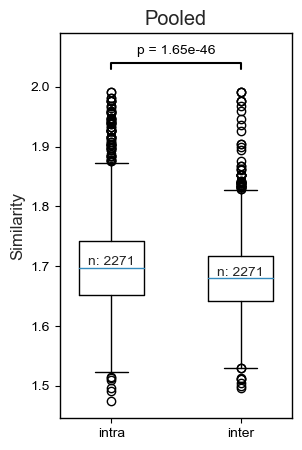

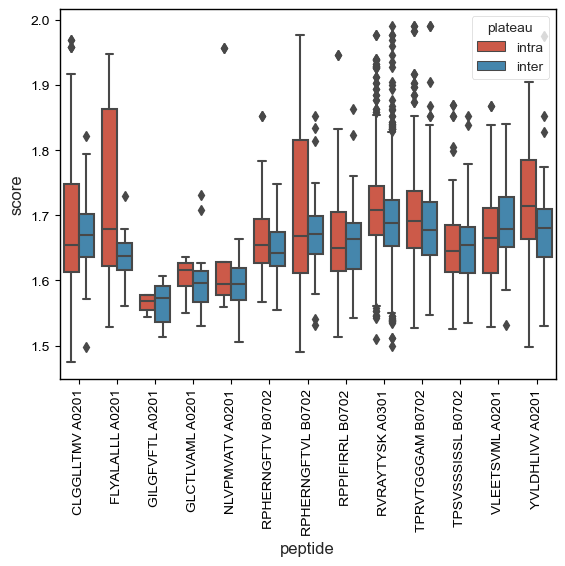

CLGGLLTMV A0201
29
29
FLYALALLL A0201
19
19
GILGFVFTL A0201
2
2
GLCTLVAML A0201
5
5
NLVPMVATV A0201
4
4
RPHERNGFTV B0702
19
19
RPHERNGFTVL B0702
36
36
RPPIFIRRL B0702
23
23
RVRAYTYSK A0301
1123
1123
TPRVTGGGAM B0702
153
153
TPSVSSSISSL B0702
24
24
VLEETSVML A0201
25
25
YVLDHLIVV A0201
94
94


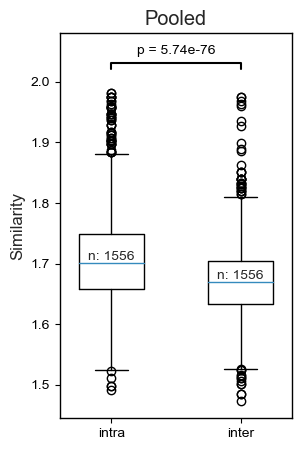

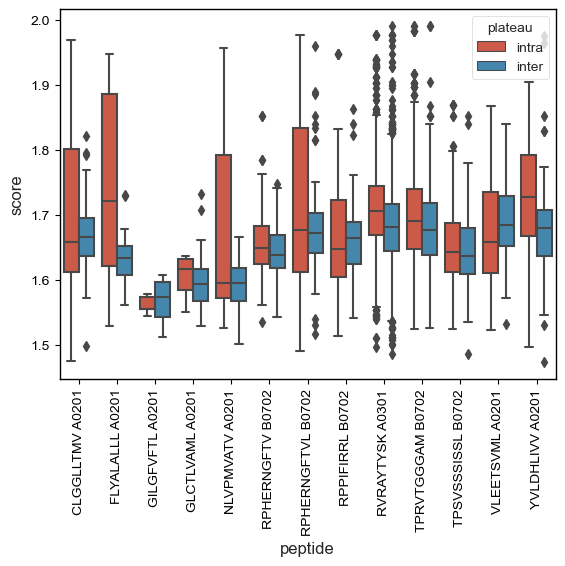

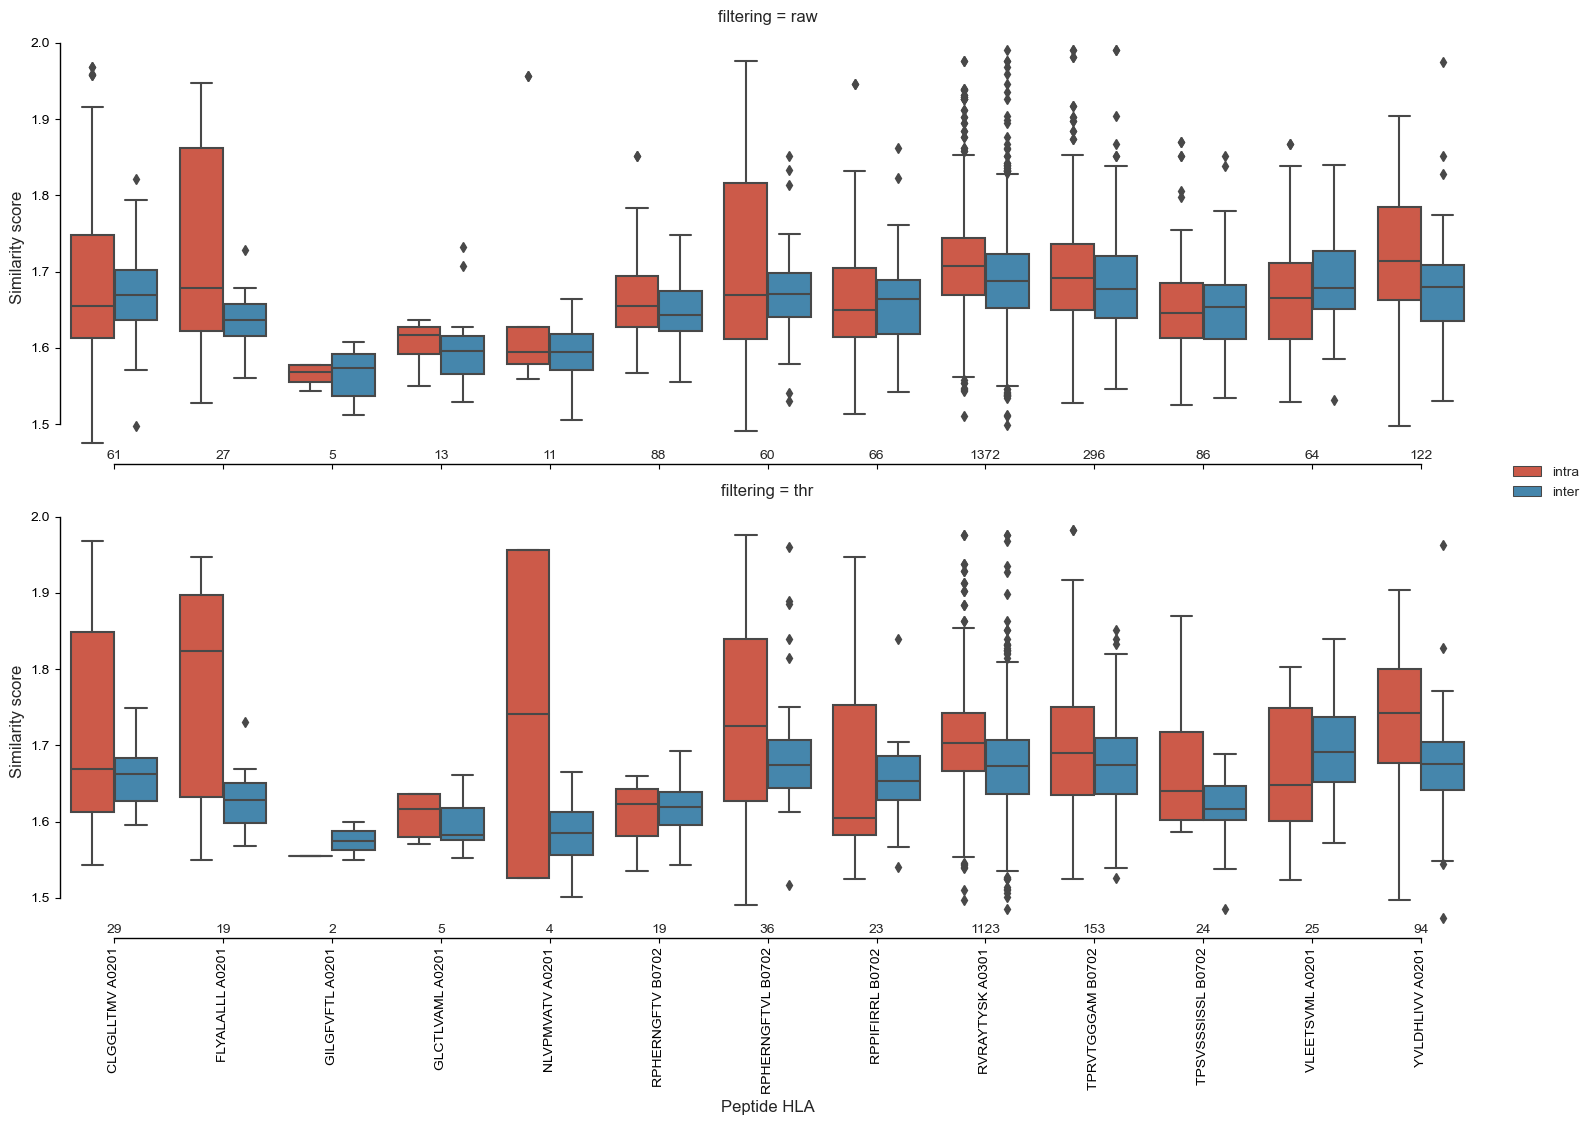

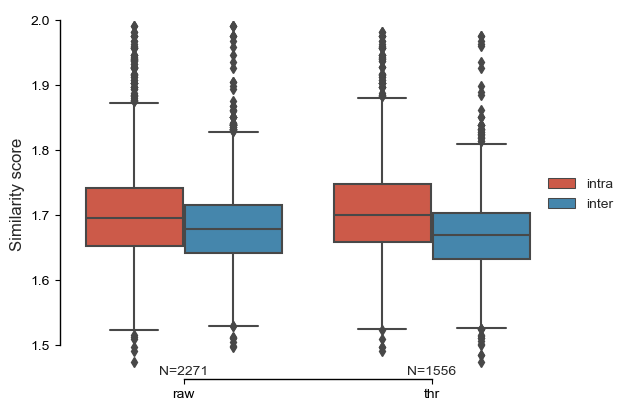

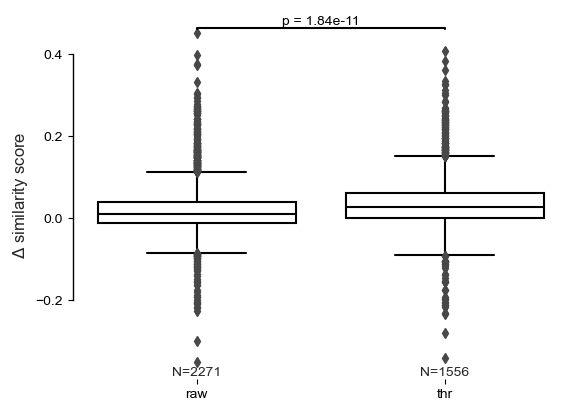

In [40]:
# TEST WITH SNS
import seaborn as sns
#sns.set_style('white')
#sns.set_context('paper') #, font_scale=2
sns.set_style('ticks', {'axes.edgecolor': '0',  
                        'xtick.color': '0',
                        'ytick.color': '0'})

#significant_simulations = list()
#n_simulations = 10
score_dct = dict()
plt_df = pd.DataFrame(columns=['score','peptide','plateau','filtering'])
intra_df = pd.DataFrame(columns=['score','peptide','plateau','filtering'])
inter_df = pd.DataFrame(columns=['score','peptide','plateau','filtering'])

#for simulation in range(n_simulations):
for data_type, sdf in [('raw', df.dropna(subset=['cdr3_TRA','cdr3_TRB']).replace('0','').fillna(0)),
                       ('thr', total.dropna(subset=['cdr3_TRA','cdr3_TRB']).replace('0','').fillna(0))]:

    intra_score = list()
    inter_score = list()
    for peptide, group in sdf.groupby('peptide_HLA'):
        print(peptide)
        if len(group) == 1:
            continue
        if len(group.drop_duplicates(['cdr3_TRA','cdr3_TRB'])) == 1:
            continue

        inter_chains = sdf.loc[sdf.peptide_HLA != peptide, ['cdr3_TRA', 'cdr3_TRB']]

        intra_score_peptide = list()
        inter_score_peptide = list()  

        # OBS! Maybe get the pairs directly instead of zipping them? Make sure you get true pairs and not just random pairs?!
        cdr3_TRAs = group.drop_duplicates(subset=['cdr3_TRA','cdr3_TRB']).cdr3_TRA.values
        cdr3_TRBs = group.drop_duplicates(subset=['cdr3_TRA','cdr3_TRB']).cdr3_TRB.values

        assert len(cdr3_TRAs) == len(cdr3_TRBs) == len(group.loc[:,['cdr3_TRA','cdr3_TRB']].drop_duplicates())

        for index, (a,b) in enumerate(zip(cdr3_TRAs, cdr3_TRBs)):
            intra = get_intra_similarity(cdr3_TRAs, cdr3_TRBs)
            inter = get_inter_similarity(cdr3_TRAs, cdr3_TRBs)

            intra_score_peptide.append(intra['score'])
            inter_score_peptide.append(inter['score'])

            intra_score.append(intra['score'])
            inter_score.append(inter['score'])

        intra_df = pd.concat([intra_df, add_data(intra_score_peptide, peptide, 'intra', data_type)])
        inter_df = pd.concat([inter_df, add_data(inter_score_peptide, peptide, 'inter', data_type)])

        #intra_df = pd.DataFrame(intra_score_peptide, columns=['score'])
        #inter_df = pd.DataFrame(inter_score_peptide, columns=['score'])
        #intra_df['group'] = 'intra'
        #inter_df['group'] = 'inter'
        #intra_df['peptide'] = peptide
        #inter_df['peptide'] = peptide

        


        tnobs = len(intra_score_peptide)
        idx = random.sample(list(np.arange(len(intra_score_peptide))), tnobs)
        ass = list(np.array(intra_score_peptide)[idx])
        ess = list(np.array(inter_score_peptide)[idx])
        #plot_boxplot(ass, ess, title=peptide)
        #plt.savefig('tcr_similarity.%s.%s.pdf'%(dataset,peptide))
        #plt.show()

    assert len(inter_score) == len(intra_score)
    #tnobs = len(intra_score)
    #intra_score_s = random.sample(intra_score, tnobs)
    #inter_score_s = random.sample(inter_score, tnobs)
    plot_boxplot(intra_score, inter_score) #intra_score_s, inter_score_s
    #plt.savefig(PLT + 'tcr_similarity.pooled.%s.pdf'%dataset)
    plt.show()

    # Plot scores per peptide
    plt_df = pd.concat([intra_df,inter_df])
    ax = sns.boxplot(x='peptide',y='score', hue='plateau', data=plt_df)
    ax.set_xticklabels(plt_df.peptide.unique(), rotation=90, ha='center')
    plt.show()

    score_dct[data_type] = list(intra_df[intra_df.filtering == data_type].score - inter_df[inter_df.filtering == data_type].score)

# Plot scores per peptide
g = sns.catplot(x="peptide", y="score",
                 hue="plateau", row="filtering",
                 data=plt_df, kind="box", aspect=3, legend=False) #, aspect=2
for ax, flt in zip(g.axes, ['raw','thr']):
    add_counts(ax[0], plt_df[plt_df.filtering == flt], "peptide", "score", plt_df.peptide.unique(), ['intra','inter'])
g.set_ylabels('Similarity score')
g.set_xlabels('Peptide HLA')
g.fig.tight_layout()
g.set_xticklabels(rotation=90, ha='center')
plt.legend(bbox_to_anchor=(1.05, 1.05), loc='center', frameon=False)
sns.despine(trim=True)
plt.show()

# Plot pooled scores
ax = sns.boxplot(x="filtering", y="score", hue="plateau", data=plt_df)
ax.set_ylabel('Similarity score')
ax.set_xlabel('')
add_counts(ax, plt_df, "filtering", "score", ['raw','thr'], ['intra','inter'])
plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center', frameon=False)
sns.despine(trim=True)
plt.show()

# Plot pooled, delta scores
comp_df = pd.DataFrame.from_dict(score_dct, orient='index').T
comp_df = pd.melt(comp_df, value_vars=['raw','thr'])
ax = sns.boxplot(x='variable',y='value', data=comp_df)
#ax.set_xticklabels(comp_df.peptide.unique(), rotation=90, ha='center')
add_significance_bar(comp_df[comp_df.variable == 'raw'].value.dropna(),
                     comp_df[comp_df.variable == 'thr'].value.dropna())
add_counts(ax, comp_df, "variable", "value", ['raw','thr'])
ax.set_xlabel('')
ax.set_ylabel(r'$\Delta$ similarity score')
plt.setp(ax.artists, edgecolor = 'k', facecolor='w')
plt.setp(ax.lines, color='k')
sns.despine(trim=True, bottom=True)
plt.show()

In [43]:
group.groupby('ct').size()

ct
2.0        1
10.0       1
18.0      50
23.0      32
32.0      25
          ..
6644.0     1
6663.0     1
6877.0     1
7017.0     1
7045.0     1
Length: 94, dtype: int64

In [47]:
sdf[sdf.peptide_HLA == peptide]

gem      clonotype  num_clonotype      ct  \
16    AAACGGGAGTGTACTC-1    clonotype18           18.0    18.0   
40    AAAGCAAGTACGAAAT-1  clonotype5377         5377.0  5377.0   
70    AACACGTGTTTGTGTG-1  clonotype4711         4711.0  4711.0   
144   AACTTTCCAATGACCT-1    clonotype35           35.0    35.0   
162   AAGCCGCCATGCTAGT-1  clonotype1212         1212.0  1212.0   
...                  ...            ...            ...     ...   
4688  TTCTTAGCAAACCCAT-1    clonotype35           35.0    35.0   
4751  TTGGAACCAGGAACGT-1  clonotype2715         2715.0  2715.0   
4799  TTTCCTCGTACCGGCT-1    clonotype18           18.0    18.0   
4807  TTTGCGCGTTCCCTTG-1   clonotype103          103.0   103.0   
4824  TTTGTCACAAGCGAGT-1    clonotype23           23.0    23.0   

                   genes_TRA                   genes_TRB  \
16    TRAV14/DV4;TRAJ42;TRAC     TRBV20-1;;TRBJ2-6;TRBC2   
40       TRAV8-1;TRAJ34;TRAC      TRBV7-6;;TRBJ2-2;TRBC2   
70       TRAV8-1;TRAJ27;TRAC      TRBV7-3;;TRBJ2-2;TRBC2   
144      TRAV8-1;TRAJ15;TRAC      TRBV6-2;;TRBJ2-1;TRBC2   
162      TRAV8-1;TRAJ34;TRAC      TRBV3-1;;TRBJ2-1;TRBC2   
...                      ...                         ...   
4688     TRAV8-1;TRAJ15;TRAC      TRBV6-2;;TRBJ2-1;TRBC2   
4751     TRAV8-1;TRAJ34;TRAC       TRBV28;;TRBJ1-2;TRBC1   
4799  TRAV14/DV4;TRAJ42;TRAC     TRBV20-1;;TRBJ2-6;TRBC2   
4807    TRAV12-2;TRAJ34;TRAC  TRBV30;TRBD1;TRBJ2-1;TRBC2   
4824      TRAV16;TRAJ18;TRAC       TRBV14;;TRBJ2-7;TRBC2   

                   genes_lst_TRA                   genes_lst_TRB  length_TRA  \
16    ['TRAV14/DV4;TRAJ42;TRAC']     ['TRBV20-1;;TRBJ2-6;TRBC2']       535.0   
40       ['TRAV8-1;TRAJ34;TRAC']      ['TRBV7-6;;TRBJ2-2;TRBC2']       565.0   
70       ['TRAV8-1;TRAJ27;TRAC']      ['TRBV7-3;;TRBJ2-2;TRBC2']       565.0   
144      ['TRAV8-1;TRAJ15;TRAC']      ['TRBV6-2;;TRBJ2-1;TRBC2']       568.0   
162      ['TRAV8-1;TRAJ34;TRAC']      ['TRBV3-1;;TRBJ2-1;TRBC2']       563.0   
...                          ...                             ...         ...   
4688     ['TRAV8-1;TRAJ15;TRAC']      ['TRBV6-2;;TRBJ2-1;TRBC2']       568.0   
4751     ['TRAV8-1;TRAJ34;TRAC']       ['TRBV28;;TRBJ1-2;TRBC1']       565.0   
4799  ['TRAV14/DV4;TRAJ42;TRAC']     ['TRBV20-1;;TRBJ2-6;TRBC2']       535.0   
4807    ['TRAV12-2;TRAJ34;TRAC']  ['TRBV30;TRBD1;TRBJ2-1;TRBC2']       538.0   
4824      ['TRAV16;TRAJ18;TRAC']       ['TRBV14;;TRBJ2-7;TRBC2']       558.0   

     cdr1_TRA  ... single_barcode_mrk multiplets_mrk  umi_count_mhc_rel  \
16    TSDPSYG  ...                0.0            0.0                0.0   
40     YGGTVN  ...                0.0            0.0                0.0   
70     YGGTVN  ...                0.0            0.0                0.0   
144    YGGTVN  ...                0.0            0.0                0.0   
162    YGGTVN  ...                0.0            0.0                0.0   
...       ...  ...                ...            ...                ...   
4688   YGGTVN  ...                0.0            0.0                0.0   
4751   YGGTVN  ...                0.0            0.0                0.0   
4799  TSDPSYG  ...                0.0            0.0                0.0   
4807   DRGSQS  ...                0.0            0.0                0.0   
4824   YSGSPE  ...                0.0            0.0                0.0   

     gems_per_specificity  gems_per_clonotype binding_concordance  \
16                     51                  52            0.980769   
40                      1                   1            1.000000   
70                      1                   1            1.000000   
144                    19                  21            0.904762   
162                     1                   1            1.000000   
...                   ...                 ...                 ...   
4688                   19                  21            0.904762   
4751                    1                   1            1.000000   
4799                   5

In [48]:
peptide

'YVLDHLIVV A0201'

In [37]:
plt_df[plt_df.filtering == flt].dropna()['peptide'].value_counts()

RVRAYTYSK A0301      2246
TPRVTGGGAM B0702      306
YVLDHLIVV A0201       188
RPHERNGFTVL B0702      72
CLGGLLTMV A0201        58
VLEETSVML A0201        50
TPSVSSSISSL B0702      48
RPPIFIRRL B0702        46
FLYALALLL A0201        38
RPHERNGFTV B0702       38
GLCTLVAML A0201        10
NLVPMVATV A0201         8
GILGFVFTL A0201         4
Name: peptide, dtype: int64

In [ ]:
import seaborn as sns
#sns.set_theme(color_codes=True)
iris = sns.load_dataset("iris")
species = iris.pop("species")
g = sns.clustermap(iris)

In [48]:
a = df.set_index('ct')[['cdr3_lst_TRA', 'cdr3_lst_TRB']].explode('cdr3_lst_TRA').explode('cdr3_lst_TRB')
#b = df.set_index('ct').explode('cdr3_lst_TRB')

In [49]:
a

cdr3_lst_TRA         cdr3_lst_TRB
ct                                          
4860.0   CAVGVRGGGNKLTF  CASSAGVGIVFGSGNTIYF
4860.0   CAVGVRGGGNKLTF     CASSVTGPPREDGYTF
2833.0   CATFNAGNNRKLIW       CASSLVAGGHEQYF
4.0     CAVRAITGGGNKLTF     CASSTPSSGPQETQYF
115.0     CAVLMDSNYQLIW       CASSADGMNTEAFF
...                 ...                  ...
2.0                             CASSYVGYEQYF
544.0                      CASSGAPGRNPFYEQYF
2011.0                       CSASRQGGFGNEQFF
2176.0                        CASSSTGGNQPQHF
4.0                         CASSTPSSGPQETQYF

[7720 rows x 2 columns]

In [56]:
sim_tra[['CAVGVRGGGNKLTF']].mean(axis=1)

CAAADRGSTLGRLYF    0.781109
CAAAGNKLTF         0.821686
CAAAGNTPLVF        0.783240
CAAAGTASKLTF       0.802031
CAAAGYGGATNKLIF    0.820995
                     ...   
CYGRNNQGGKLIF      0.793577
CYGTSGTYKYIF       0.752681
CYNFNKFYF          0.666158
CYPDTPLVF          0.673594
                   0.000000
Length: 4761, dtype: float64

In [54]:
sim_trb[['CASSAGVGIVFGSGNTIYF','CASSVTGPPREDGYTF']].mean(axis=1)

CAADYEQYF          0.659047
CAAGEGGSYNEQFF     0.718160
CAAGEGSPLHF        0.725714
CAAGGTFSYEQYF      0.716612
CAAIGGNEQYF        0.717683
                     ...   
CVPPIQQNSYNEQFF    0.663663
CYEQYF             0.573875
CYGYTF             0.601112
CYRRGRAVVGYTF      0.701862
                   0.000000
Length: 5868, dtype: float64

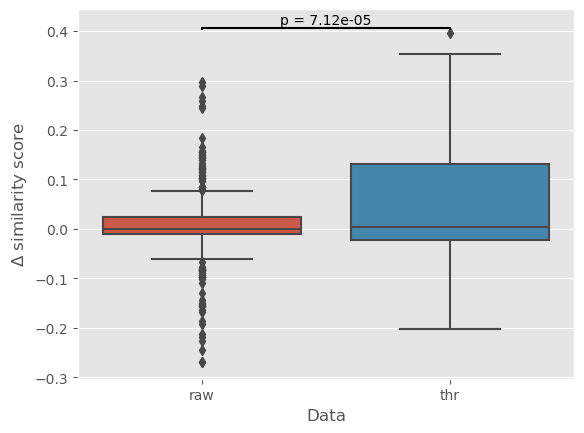

In [71]:
comp_df = pd.DataFrame.from_dict(score_dct, orient='index').T
comp_df = pd.melt(comp_df, value_vars=['raw','thr'])
ax = sns.boxplot(x='variable',y='value', data=comp_df)
#ax.set_xticklabels(comp_df.peptide.unique(), rotation=90, ha='center')
add_significance_bar(comp_df[comp_df.variable == 'raw'].value.dropna(),
                     comp_df[comp_df.variable == 'thr'].value.dropna())
ax.set_xlabel('Data')
ax.set_ylabel(r'$\Delta$ similarity score')
plt.show()

In [59]:
stats.ttest_ind(comp_df[comp_df.variable == 'raw'].value.dropna(),
                comp_df[comp_df.variable == 'thr'].value.dropna(), equal_var=False, nan_policy='omit', alternative='less')

Ttest_indResult(statistic=-3.96513282627692, pvalue=7.12088605290385e-05)

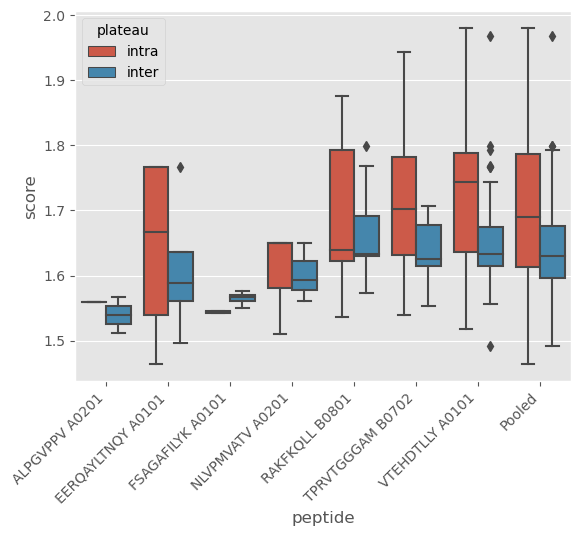

In [80]:
import seaborn as sns

ax = sns.boxplot(x='peptide',y='score', hue='plateau', data=p_df)
ax.set_xticklabels(p_df.peptide.unique(), rotation=45, ha='right')
plt.show()

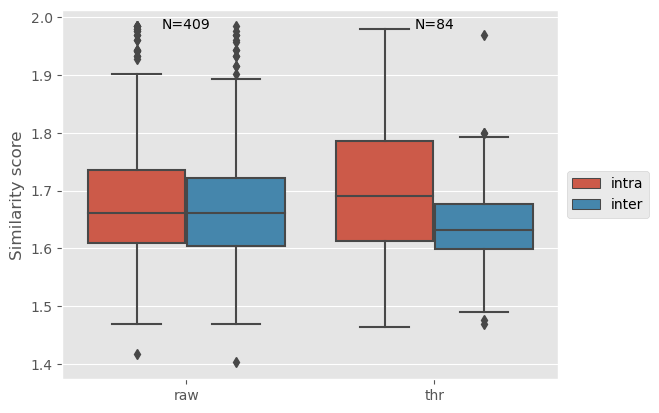

In [220]:
x_col='filtering'
y_col='score'
order=['raw','thr']
hue_col='plateau'
hue_order=['intra','inter']
width=0.8

ax = sns.boxplot(x="filtering", y="score",
                 hue="plateau",
                 data=plt_df) #, aspect=2
ax.set_ylabel('Similarity score')
ax.set_xlabel('')

#g.set_xticklabels(rotation=90, ha='center')
#plt.subplots_adjust(wspace = 0.03)
plt.legend(bbox_to_anchor=(1.1, 0.5), loc='center')

#n_levels = len(plt_df[hue_col].unique())
#each_width = width / n_levels
#offsets = np.linspace(0, width - each_width, n_levels)
#offsets -= offsets.mean()
#
#pos = [x+o for x in np.arange(len(order)) for o in offsets]
#
#counts = plt_df.groupby([x_col,hue_col])[y_col].size()
#counts = counts.reindex(pd.MultiIndex.from_product([order,hue_order]))
#medians = plt_df.groupby([x_col,hue_col])[y_col].median()
#medians = medians.reindex(pd.MultiIndex.from_product([order,hue_order]))
#
#pos = [0,1]
#counts = plt_df.groupby([x_col])[y_col].size()/2
#counts = counts.reindex(order)
#medians = pd.Series([2]*2, index=order)
#
#for p,n,m in zip(pos,counts,medians):
#    if not np.isnan(m):
#        print(p,n,m)
#        ax.annotate('N={:.0f}'.format(n), xy=(p, m), xycoords='data', ha='center', va='top')
#
add_counts(ax, plt_df, x_col, y_col, order)
plt.show()

In [248]:
def add_counts(ax, plt_df, x_col, y_col, order, hue=None):
    if hue is None:
        d = 1
    else:
        d = len(hue)
    
    y_min = round(ax.get_ylim()[0], 2)
    x_pos = np.arange(len(order))
    y_pos = pd.Series([y_min]*len(order), index=order)
    counts = plt_df.dropna()[x_col].value_counts()/d
    counts = counts.reindex(order)
    
    if len(order) > 5:
        txt = '{:.0f}'
    else:
        txt = 'N={:.0f}'

    for p,n,m in zip(x_pos,counts,y_pos):
        if not np.isnan(m):
            ax.annotate(txt.format(n), xy=(p, m), xycoords='data', ha='center', va='bottom')


In [246]:
plt_df.dropna()[x_col].value_counts()

raw    818
thr    168
Name: filtering, dtype: int64

In [245]:
comp_df.dropna().variable.value_counts()

raw    409
thr     84
Name: variable, dtype: int64

In [244]:
comp_df

variable     value
0        raw -0.049402
1        raw -0.129286
2        raw  0.000000
3        raw  0.000000
4        raw  0.000000
..       ...       ...
813      thr       NaN
814      thr       NaN
815      thr       NaN
816      thr       NaN
817      thr       NaN

[818 rows x 2 columns]

In [199]:
plt_df.groupby([x_col,hue_col])[y_col].min()

filtering  plateau
raw        inter      1.402456
           intra      1.417778
thr        inter      1.469130
           intra      1.463863
Name: score, dtype: float64

In [204]:
pd.Series([plt_df.score.min()-0.1]*2, index=order)

raw    1.302456
thr    1.302456
dtype: float64

In [197]:
medians['bottom'] = 1.3

In [198]:
medians

raw     intra    1.660432
        inter    1.660396
thr     intra     1.69067
        inter    1.631472
bottom                1.3
Name: score, dtype: object

In [38]:
intra_df = pd.DataFrame(intra_score_peptide, columns=['score'])
inter_df = pd.DataFrame(inter_score_peptide, columns=['score'])

intra_df['group'] = 'intra'
inter_df['group'] = 'inter'
intra_df['peptide'] = peptide
inter_df['peptide'] = peptide

In [40]:
plt_df = pd.concat([plt_df, pd.concat([intra_df, inter_df])])

score  group          peptide
0   1.876505  intra  WPRAPRGQI B0801
1   1.626420  intra  WPRAPRGQI B0801
2   1.968580  intra  WPRAPRGQI B0801
3   1.767455  intra  WPRAPRGQI B0801
4   1.968580  intra  WPRAPRGQI B0801
..       ...    ...              ...
36  1.686146  inter  WPRAPRGQI B0801
37  1.678682  inter  WPRAPRGQI B0801
38  1.620378  inter  WPRAPRGQI B0801
39  1.639599  inter  WPRAPRGQI B0801
40  1.572385  inter  WPRAPRGQI B0801

[82 rows x 3 columns]

AALPGVPPV A0201


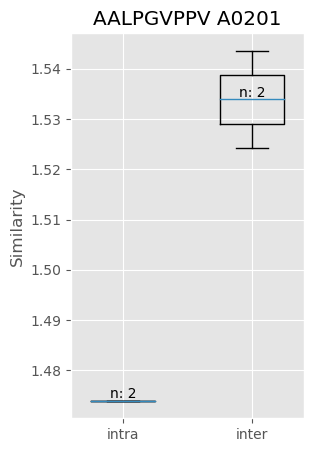

ALPGVPPV A0201


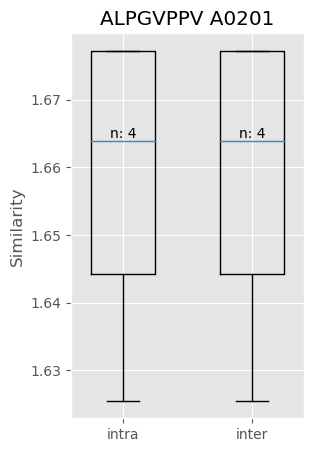

AMLIRDRL B0801


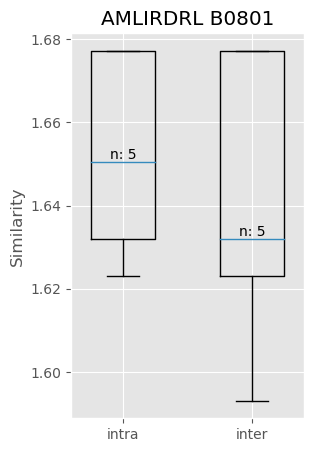

ATTADVDAGSL A0101


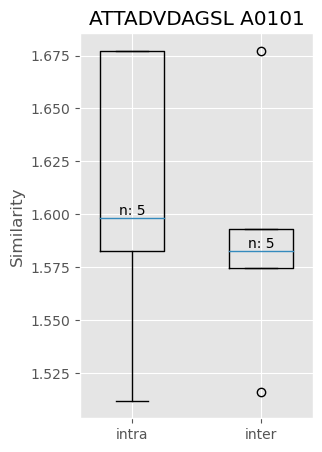

AYLTNQYM A2401


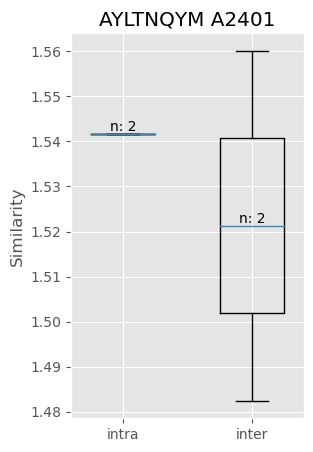

CSSVDIHF A0101


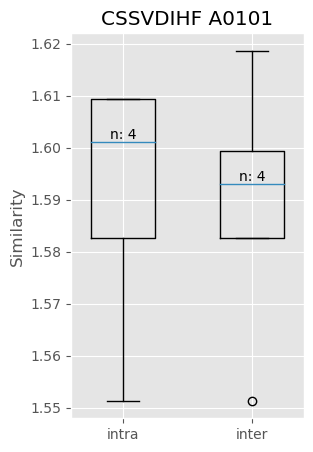

DEYVHNTTA B0801


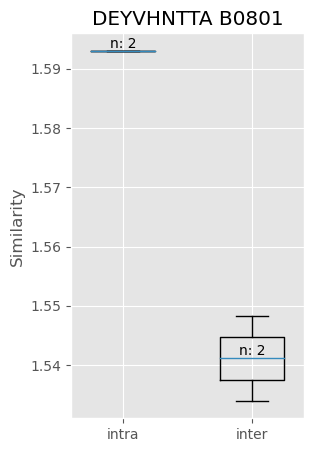

EERQAYLTNQY A0101


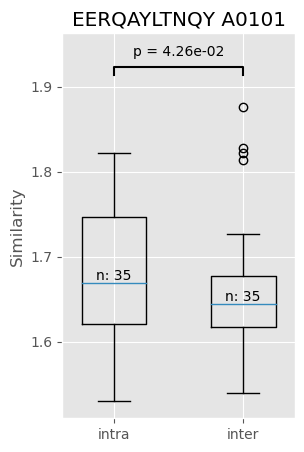

FLDTNQVV A0201


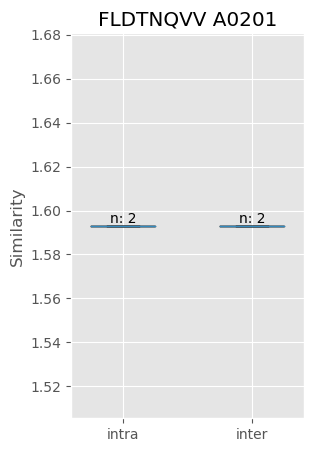

FLDTNQVVRI A0201


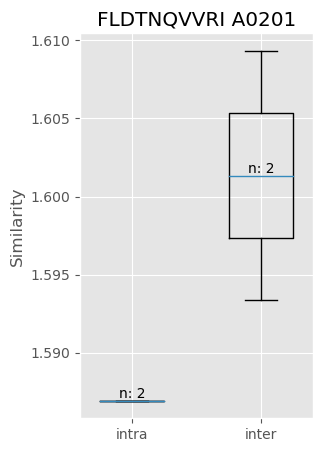

FLVNTMCLAL A0201


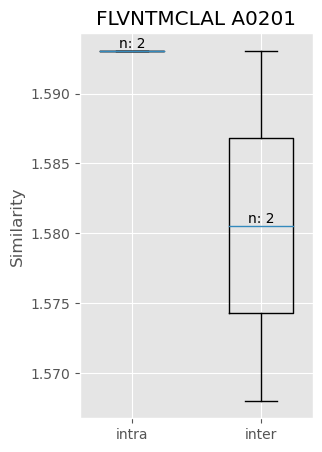

FSAGAFILYK A0101


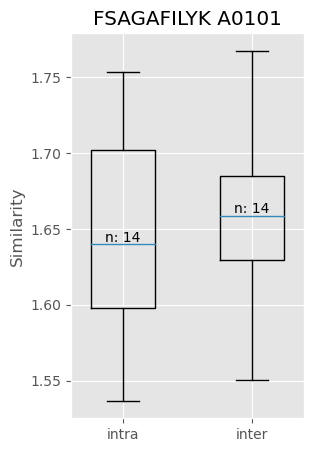

FSAGAFILYN A0101
GLFSAGAFIL A2401


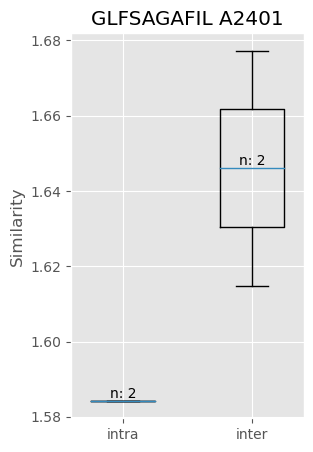

GMAEGATTA A0101


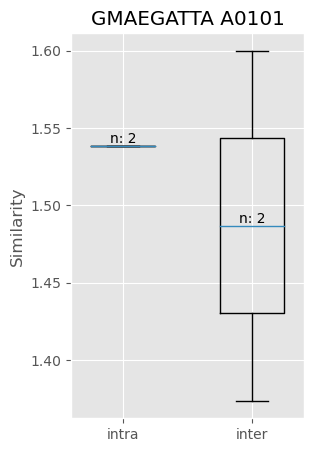

GPFPGNLV B0702
GPFPGNLVD B0702


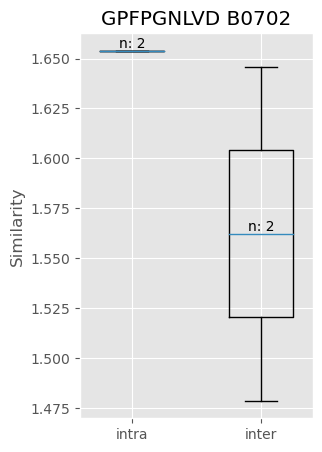

GPFPGNLVDV B0702


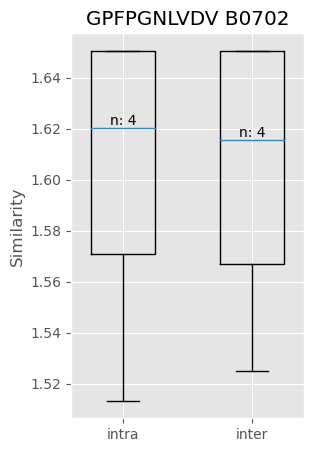

GPKPAKPCSGA B0702
GPRSERRKW B0702
HTGEKHYAC B0801


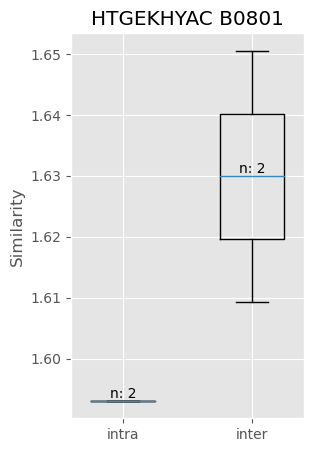

ICSSVDIHF A0101


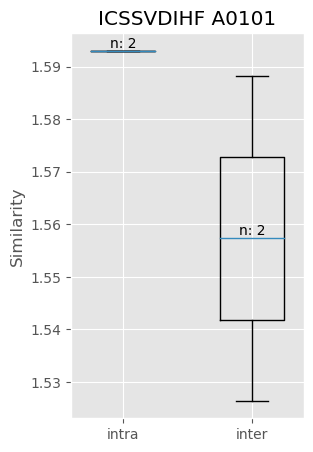

IGLFSAGAFI A2401
IHFDPGFEEQ A0101


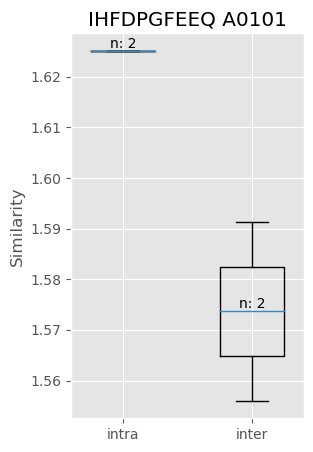

IHFDPGFEEQL A2401
ILKEPVHGV A0201


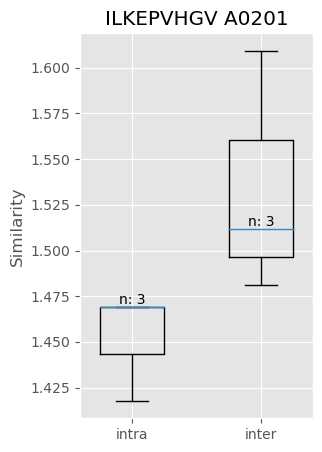

ILLFERPHTM B0801
IRHKRQSW B0801


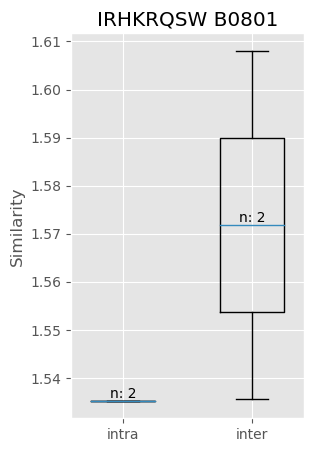

IRHKRQSWV B0801


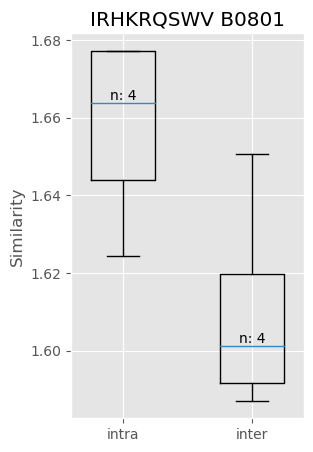

KVPAQRLQEA B0702
LFSAGAFI A2401
LFSAGAFILYN A0101


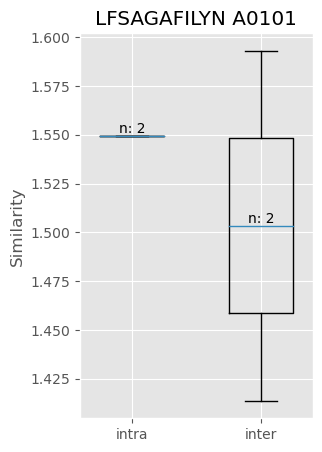

LTNQYMQRM A0101
NLVPMVATV A0201


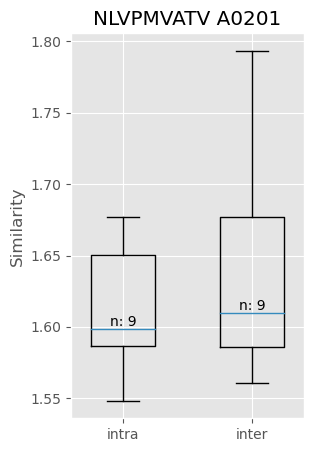

PSTPLKPL B0702
QAYLTNQY A0101


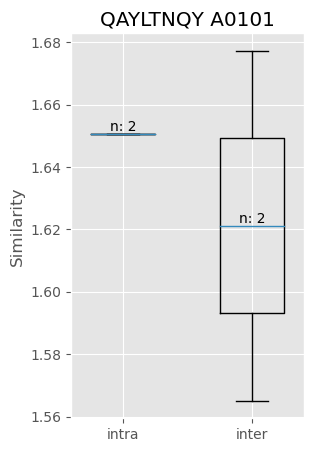

RAKFKQLL B0801


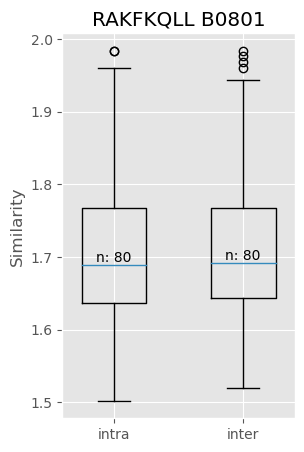

RQAYLTNQY A0101


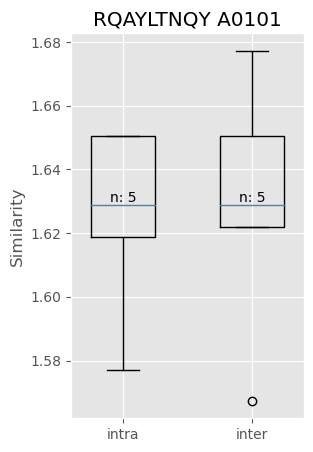

RRKVPAQRL B0801


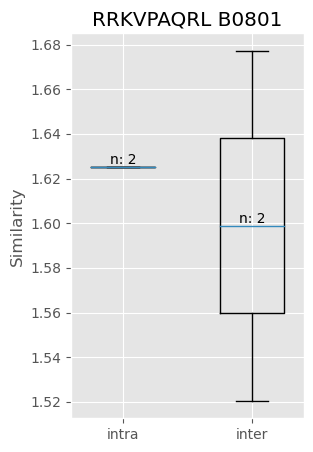

RTMFWGPEV A0201


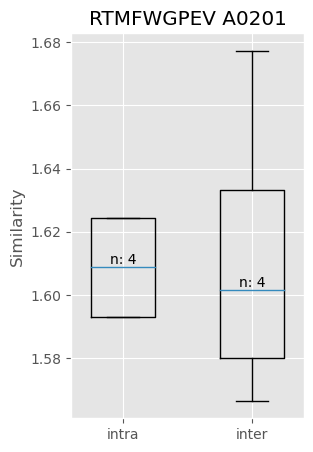

SAGAFILYK A0101


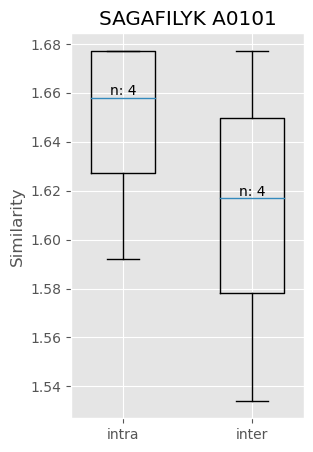

SIKDGLPPV A0201
SLIIQFTSFV A0201


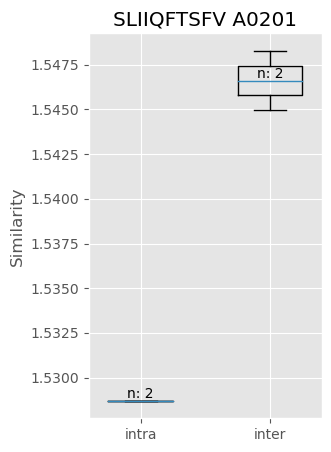

SQKVLRHM B0801


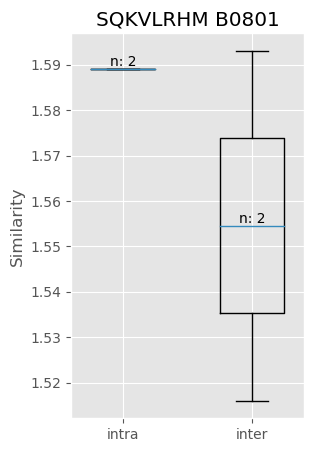

SQSDQTSEL B0801
SSGYRIGQF B0801
SSTEALISV A0201


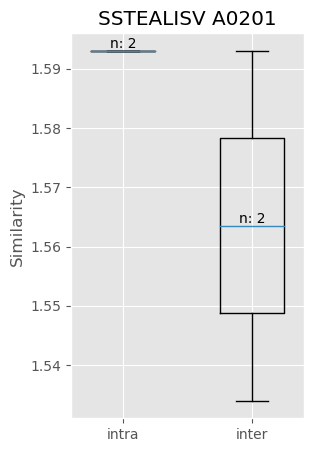

SVDIHFDPG A0101


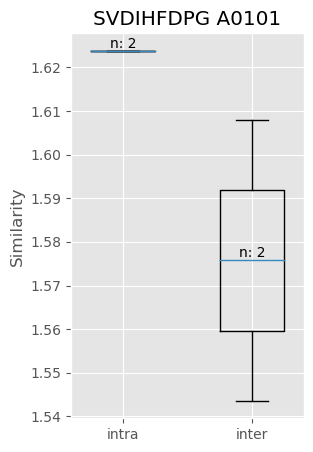

SVDIHFDPGF A0101


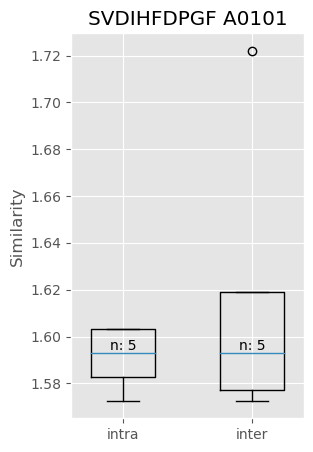

TADVDAGSLS A0101


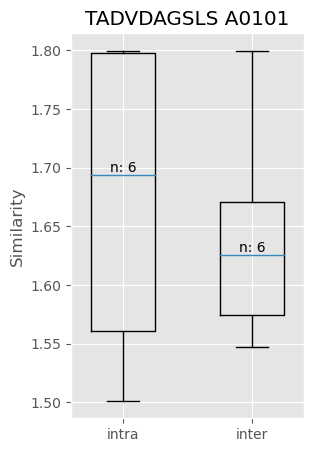

TKFIQTITL B0801
TNQYMQRMASV A2401


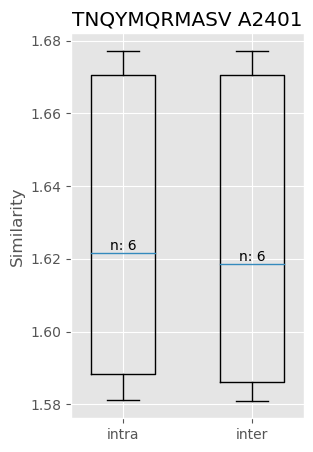

TPRVTGGGAM B0702


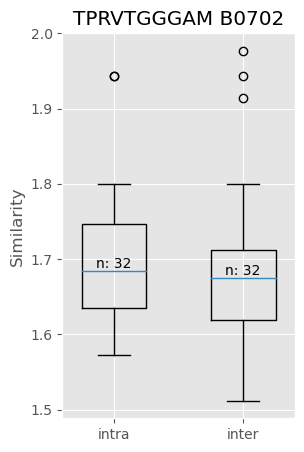

VIRHKRQSW B0801
VPAQRLQEA B0801
VTEHDTLLY A0101


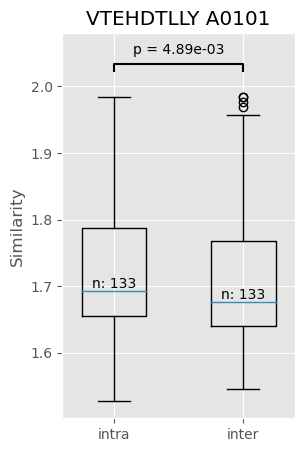

WPRAPRGQ B0702


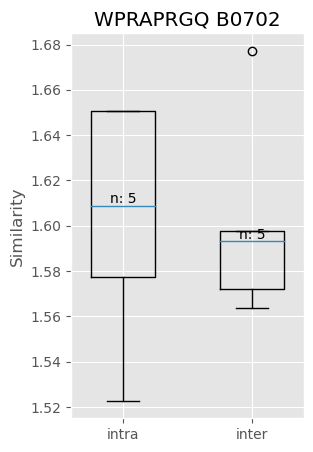

WPRAPRGQI B0801
YLFHKEPTW A0201
YPLVKMRL B0801
YPLVKMRLSV B0702


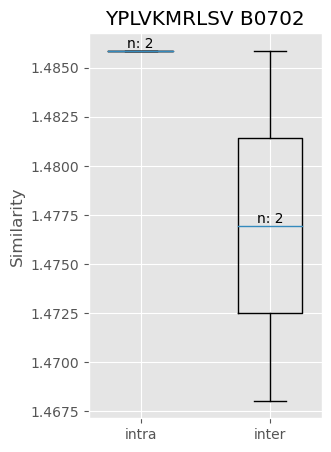

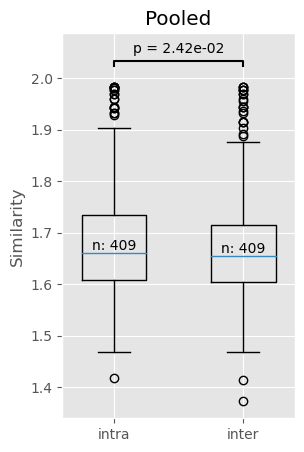

In [71]:
intra_score = list()
inter_score = list()
significant_simulations = list()
n_simulations = 10

#for simulation in range(n_simulations):
for peptide, group in sdf.groupby('peptide_HLA'):
    print(peptide)
    if len(group) == 1:
        continue
    if len(group.drop_duplicates(['cdr3_TRA','cdr3_TRB'])) == 1:
        continue

    inter_chains = sdf.loc[sdf.peptide_HLA != peptide, ['cdr3_TRA', 'cdr3_TRB']]

    intra_score_peptide = list()
    inter_score_peptide = list()  

    # OBS! Maybe get the pairs directly instead of zipping them? Make sure you get true pairs and not just random pairs?!
    cdr3_TRAs = group.drop_duplicates(subset=['cdr3_TRA','cdr3_TRB']).cdr3_TRA.values
    cdr3_TRBs = group.drop_duplicates(subset=['cdr3_TRA','cdr3_TRB']).cdr3_TRB.values
    
    assert len(cdr3_TRAs) == len(cdr3_TRBs) == len(group.loc[:,['cdr3_TRA','cdr3_TRB']].drop_duplicates())
    


    for index, (a,b) in enumerate(zip(cdr3_TRAs, cdr3_TRBs)):
        intra = get_intra_similarity(cdr3_TRAs, cdr3_TRBs)
        inter = get_inter_similarity(cdr3_TRAs, cdr3_TRBs)

        intra_score_peptide.append(intra['score'])
        inter_score_peptide.append(inter['score'])

        intra_score.append(intra['score'])
        inter_score.append(inter['score'])
    
    
    tnobs = len(intra_score_peptide)
    idx = random.sample(list(np.arange(len(intra_score_peptide))), tnobs)
    ass = list(np.array(intra_score_peptide)[idx])
    ess = list(np.array(inter_score_peptide)[idx])
    plot_boxplot(ass, ess, title=peptide)
    #plt.savefig('tcr_similarity.%s.%s.pdf'%(dataset,peptide))
    plt.show()

assert len(inter_score) == len(intra_score)
#tnobs = len(intra_score)
#intra_score_s = random.sample(intra_score, tnobs)
#inter_score_s = random.sample(inter_score, tnobs)
plot_boxplot(intra_score, inter_score) #intra_score_s, inter_score_s
plt.savefig(PLT + 'tcr_similarity.pooled.%s.pdf'%dataset)
plt.show()

In [100]:
sim_dct[dataset] = np.array(intra_score) - np.array(inter_score)

In [101]:
print(sim_dct.keys())

dict_keys(['old.total.14.2.0.2', 'old.raw', 'new.raw'])


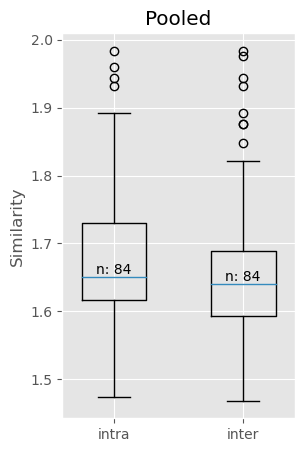

In [73]:
tnobs = 84
idx = random.sample(list(np.arange(len(intra_score))), tnobs)

intra_score_s = list(np.array(intra_score)[idx])
inter_score_s = list(np.array(inter_score)[idx])
plot_boxplot(intra_score_s, inter_score_s)
plt.savefig(PLT + 'tcr_similarity.pooled.%s.downsampled.pdf'%dataset)
plt.show()

# Bayes

In [28]:
import arviz as az
import pymc3 as pm


In [29]:
# OBS!
len(inter_score) == len(intra_score)

True

In [30]:
y = inter_score + intra_score

mu = np.mean(y)
sd = np.std(y) * 2

with pm.Model() as model:
    intra_mean = pm.Normal("intra_mean", mu=mu, sd=sd)
    inter_mean = pm.Normal("inter_mean", mu=mu, sd=sd)

In [31]:
sd_low = 0.1
sd_high = 2

with model:
    intra_std = pm.Uniform("intra_std", lower=sd_low, upper=sd_high)
    inter_std = pm.Uniform("inter_std", lower=sd_low, upper=sd_high)

In [32]:
with model:
    nu = pm.Exponential("nu_minus_one", 1 / 29.0) + 1

In [33]:
with model:
    l1 = intra_std ** -2
    l2 = inter_std ** -2

    intra = pm.StudentT("intra", nu=nu, mu=intra_mean, lam=l1, observed=intra_score)
    inter = pm.StudentT("inter", nu=nu, mu=inter_mean, lam=l2, observed=inter_score)

In [34]:
with model:
    diff_of_means = pm.Deterministic("difference of means", intra_mean - inter_mean)
    diff_of_stds = pm.Deterministic("difference of stds", intra_std - inter_std)
    effect_size = pm.Deterministic(
        "effect size", diff_of_means / np.sqrt((intra_std ** 2 + inter_std ** 2) / 2)
    )

In [35]:
with model:
    trace = pm.sample(10000, tune=5000) #3000

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu_minus_one, inter_std, intra_std, inter_mean, intra_mean]
Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:27<00:00, 2195.64draws/s]


In [36]:
pm.summary(trace, ["difference of means", "difference of stds", "effect size"])

/Users/herpov/opt/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
difference of means  0.009  0.007  -0.005    0.023        0.0      0.0   
difference of stds   0.001  0.003  -0.004    0.006        0.0      0.0   
effect size          0.086  0.073  -0.048    0.225        0.0      0.0   

                     ess_mean   ess_sd  ess_bulk  ess_tail  r_hat  
difference of means   35352.0  28093.0   35356.0   26340.0    1.0  
difference of stds    33737.0  31111.0   32379.0   31269.0    1.0  
effect size           35524.0  28273.0   35527.0   26465.0    1.0

/Users/herpov/opt/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


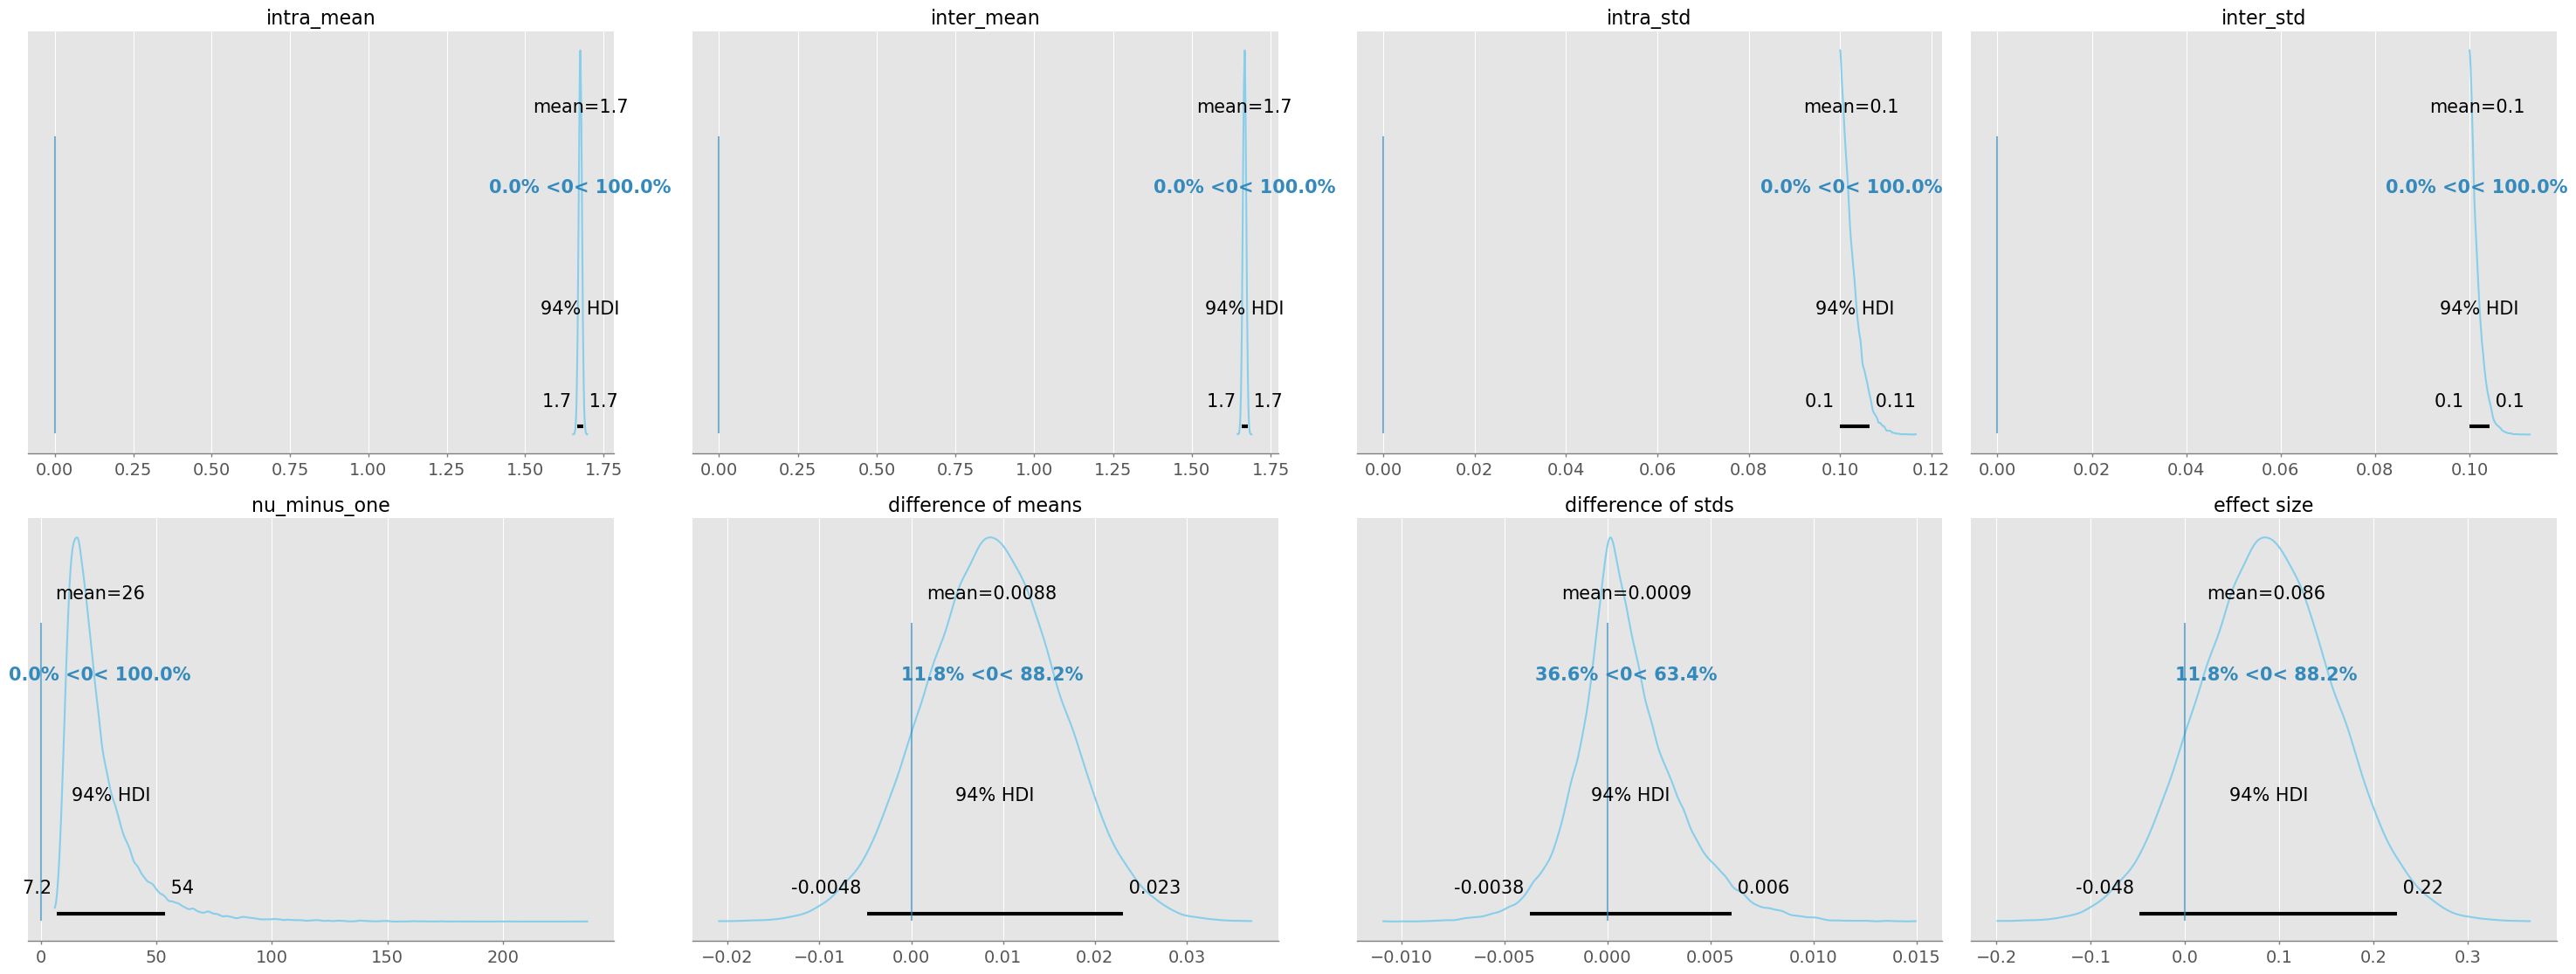

In [37]:
# Train 14.2.0.5
pm.plot_posterior(
    trace,
    ref_val=0,
    color="#87ceeb",
);
plt.show()

/Users/herpov/opt/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


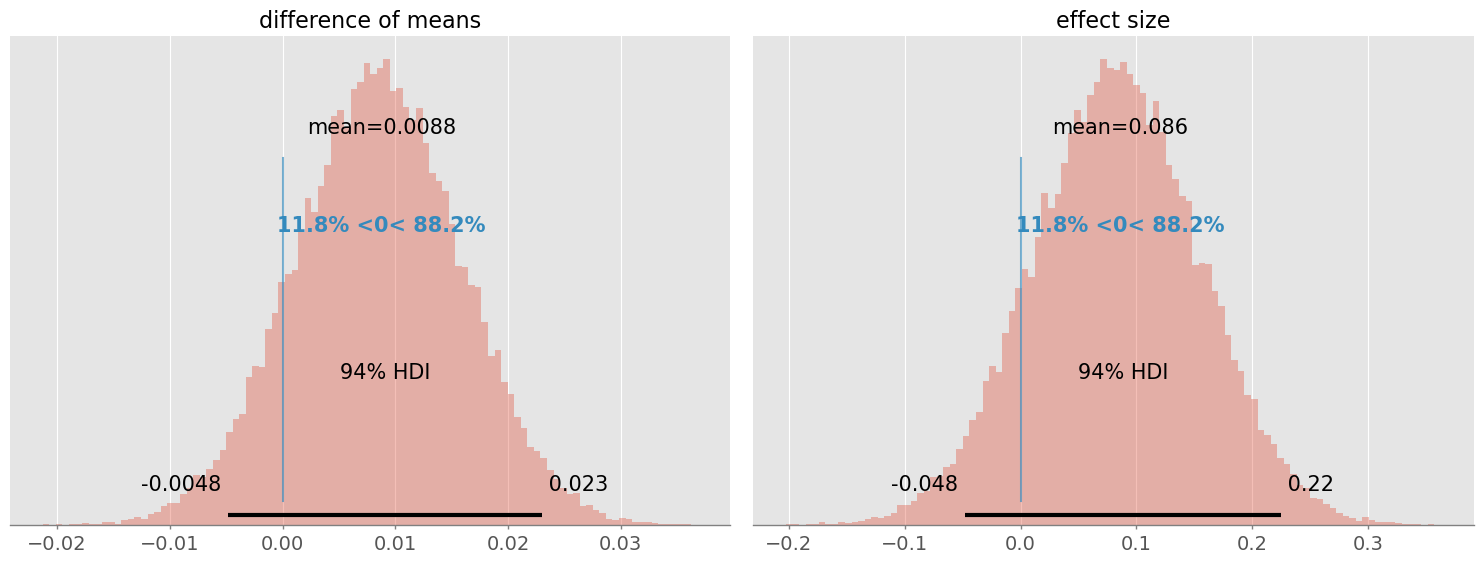

In [38]:
pm.plot_posterior(trace, var_names=['difference of means', 'effect size'], ref_val=0.0, kind='hist')
plt.savefig(PLT + 'tcr_similarity.bayes.%s.pdf'%dataset, bbox_inches='tight')
plt.show()

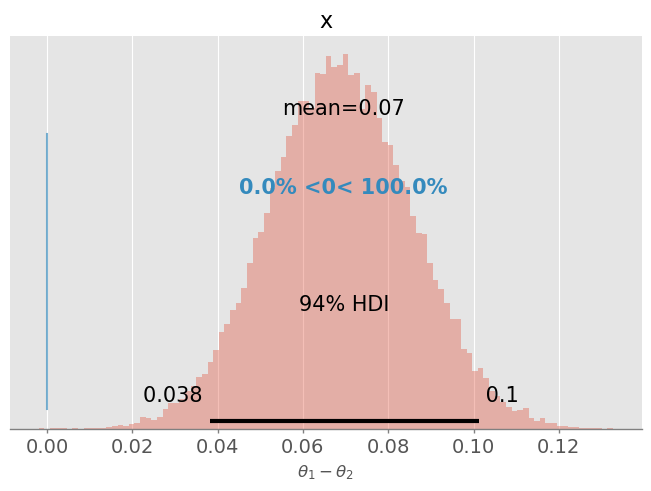

In [55]:
# Test 14.2.0.5
# create an array with the posterior sample
theta1_sample = trace['intra_mean']
theta2_sample = trace['inter_mean']


theta_diff = theta1_sample - theta2_sample
pm.plot_posterior(theta_diff, ref_val=0.0, kind='hist') #, alpha_level=0.05, color='skyblue'
plt.xlabel(r'$\theta_1 - \theta_2$')
plt.savefig('tcr_similarity.bayes.%s.pdf'%dataset, bbox_inches='tight')
plt.show()

Text(0.5, 0, '$\\theta_1 - \\theta_2$')

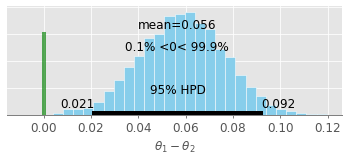

In [199]:
# Total 14.2.0.5
# create an array with the posterior sample
theta1_sample = trace['intra_mean']
theta2_sample = trace['inter_mean']


theta_diff = theta1_sample - theta2_sample
pm.plot_posterior(theta_diff, ref_val=0.0, bins=30, color='skyblue', alpha_level=0.05)
plt.xlabel(r'$\theta_1 - \theta_2$')

Text(0.5, 0, '$\\theta_1 - \\theta_2$')

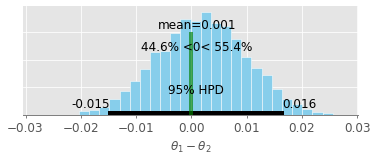

In [237]:
# Trash 14.2.0.5
# create an array with the posterior sample
theta1_sample = trace['intra_mean']
theta2_sample = trace['inter_mean']


theta_diff = theta1_sample - theta2_sample
pm.plot_posterior(theta_diff, ref_val=0.0, bins=30, color='skyblue', alpha_level=0.05)
plt.xlabel(r'$\theta_1 - \theta_2$')